# Machine Learning 521 Final Report
## Predicting Quarterly Earnings per Share with Time Series Data
#### Random Forest Regression - Bhavesh Kumar
#### Gradient Boosted Regressor Trees - Hank Beck
#### Support Vector Machine  - Bhavesh Kumar
#### Kmean Regime Clustering and Markov Chain - Kevin Zhang
#### Recurrent Neural Network - Franco Rey
#### Vanilla Neural Network - Bhavesh Kumar

# Introduction
    - What is the problem?
    - What are traditional methods for forecasting returns?
    - What is the benefit of machine learning to this problem
    - What models did we choose to explore


# Data

## Target
    - Reported EPS
    
## Features
    
## Data Sources
    - Yahoo finance
    - Alpha Vantage
    
## Things that needed to be accounted for
    - look ahead bias
    - Information available when predictions are to be made
    - Stationarity 
    - survivorship Bias
    
## Pros of the data set

## Cons of dataset

## Ways the dataset could be theorectically improved if more data available
    - longer time period
        

# Data Fetching and Cleaning
I will work here before merging with main so we have a backup in case someone messes up a merge with their independent branch

In [9]:
# import modules
import pandas as pd
import pandas_datareader as pdr
import requests
import os
from dotenv import load_dotenv
import csv
import numpy as np

# Modules for fetching data
import yfinance as yf

In [10]:
load_dotenv()
AV_api_key = os.getenv("ALPHA_VANTAGE_API_KEY")

## Helper functions

### Data retrieval and cleanup helper functions

In [11]:

def DeleteEmptyCSVs(CSVToCheck):
    # Function to delete any csvs that were created by an attempted data retrieval
    # but are empty of data
    if os.path.isfile(CSVToCheck):
        # Count the number of lines in the file
        with open(CSVToCheck, 'r') as file:
            reader = csv.reader(file)
            line_count = sum(1 for row in reader)
        
        print(f"The file {CSVToCheck} has {line_count} lines.")

        # Check if the line count is less 3 (header and empty line)
        if line_count < 3:
            print(f"{CSVToCheck} seems empty. Deleting the file.")
            os.remove(CSVToCheck)
        else:
            print(f"{CSVToCheck} seems to have data.")
    else:
        print(f"{CSVToCheck} does not exist.")

In [12]:
def getYahoo(tckr, tckr_csv):
    
    if not os.path.isfile(tckr_csv):
        print("Retrieving "+tckr+" Data from Yahoo...")
        try:
            tckr_data = yf.download(tckr, start=START_DATE_yahoo, end=END_DATE_yahoo)
            print("saving data to csv")
            tckr_data.to_csv(tckr_csv)
        except Exception as e:
            print(f"Failed to retrieve data: {e}")
    else:
        print(tckr+" data already saved in csv")



In [13]:
def getDividends(tckr):
    ticker = yf.Ticker(tckr)
    dividends_series = ticker.dividends
    csvFile = './data_files/'
    csvFile = csvFile + tckr + 'dividends.csv'
    dividends_series.to_csv(csvFile)

In [14]:
def GetEarningsFromAlphaVantage(stock_ticker, data_folder = 'data_files'):
    # Request from API
    url = f'https://www.alphavantage.co/query?function=EARNINGS&symbol={stock_ticker}&apikey={AV_api_key}'
    response = requests.get(url)
    data = response.json()
    quarterly_file =  stock_ticker + 'quarterlyEarnings.csv'
    #annual_file =  stock_ticker + 'annualEarnings.csv'
    quarterly_csv = os.path.join(data_folder, quarterly_file)
    #annual_csv = os.path.join(data_folder, annual_file)
    # Parse the response to get EPS data and save it as a CSV file
    quarterly_earnings = data['quarterlyEarnings']
    #annual_earnings = data['annualEarnings']
    if not os.path.isfile(quarterly_csv):
        with open(quarterly_csv, mode='w', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(['Fiscal Date','Estimated EPS', 'Reported EPS'])  # Write header row
            for earnings_data in quarterly_earnings:
                fiscal_date = earnings_data['fiscalDateEnding']
                estimated_eps = earnings_data['estimatedEPS']
                reported_eps = earnings_data['reportedEPS']
                writer.writerow([fiscal_date, estimated_eps, reported_eps])
    else:
        print("Quarterly Earnings CSV already present")
    # Report save
        
    print(f" Quarterly Earnings data saved to {quarterly_csv}")
    
    

In [15]:
def BalanceSheetFromAlphaVantage(stock_ticker, data_folder = 'data_files'):
    # Request from API
    url = 'https://www.alphavantage.co/query?function=BALANCE_SHEET&symbol=IBM&apikey=demo'
    response = requests.get(url)
    data = response.json()
    quarterly_file =  stock_ticker + 'quarterlyBalSheet.csv'
    #annual_file =  stock_ticker + 'annualEarnings.csv'
    quarterly_csv = os.path.join(data_folder, quarterly_file)
    #annual_csv = os.path.join(data_folder, annual_file)
    # Parse the response to get EPS data and save it as a CSV file
    quarterly_reports = data['quarterlyReports']
    #annual_earnings = data['annualEarnings']
    if not os.path.isfile(quarterly_csv):
        with open(quarterly_csv, mode='w', newline='') as file:
            writer = csv.writer(file)
            balance_sheet_items = list(quarterly_reports[0].keys())
            writer.writerow(balance_sheet_items)  # Write header row
            for report in quarterly_reports:
                curr_row = []
                for item in balance_sheet_items:
                    curr_row.append(report[item])
                writer.writerow(curr_row)
    else:
        print("Quarterly Earnings CSV already present")
    # Report save
        
    print(f" Quarterly Earnings data saved to {quarterly_csv}")
    
    

## Fetching Initial Data

### Sourced from yahoo

In [16]:
START_DATE_yahoo ="1990-01-01"
END_DATE_yahoo = "2024-05-30"

# Larger Market trends 

# S&P 500
sp500_ticker = '^GSPC'
sp500_csv = './data_files/sp500_RawData.csv'
START_DATE_sp500 = START_DATE_yahoo
END_DATE_sp500 = END_DATE_yahoo

# CBOE Volatility Index (VIX)
vix_ticker = '^VIX'
vix_csv = './data_files/VIX_RawData.csv'
START_DATE_vix = START_DATE_yahoo
END_DATE_vix = END_DATE_yahoo

# Large Cap Stocks

# Microsoft (MSFT)
micro_ticker = 'MSFT'
micro_csv = './data_files/MSFT_RawData.csv'
micro_earnings_csv = './data_files/MSFTquarterlyEarnings.csv'
micro_balSht_csv = './data_files/MSFTquarterlyBalSheet.csv'
START_DATE_msft = START_DATE_yahoo
END_DATE_msft = END_DATE_yahoo

# General Electric (GE)
general_elec_ticker = 'GE'
ge_csv = './data_files/GE_RawData.csv'
START_DATE_ge = START_DATE_yahoo
END_DATE_ge = END_DATE_yahoo

# Johnson and Johnson (JNJ)
jj_ticker = 'JNJ'
jj_csv = './data_files/JNJ_RawData.csv'
jj_earnings_csv = './data_files/JNJquarterlyEarnings.csv'
jj_balSht_csv = './data_files/JNJquarterlyBalSheet.csv'
jj_dividend_csv = './data_files/JNJdividends.csv'
START_DATE_jj = START_DATE_yahoo
END_DATE_jj = END_DATE_yahoo

# Coca Cola (KO)
cc_ticker = 'KO'
cc_csv = './data_files/KO_RawData.csv'
START_DATE_cc = START_DATE_yahoo
END_DATE_cc = END_DATE_yahoo


## S&P 500 (representative of of larger market trends)

In [17]:
#getYahoo(sp500_ticker, sp500_csv)

## VIX (overall market volatility)

In [18]:
#getYahoo(vix_ticker,vix_csv)

## Johnson and Johnson Historical Stock Price

In [19]:
#getYahoo(jj_ticker, jj_csv)

## Microsoft Historical Stock Price

In [20]:
#getYahoo(micro_ticker,micro_csv)

## Dividend data

In [21]:
#getDividends(jj_ticker)

In [22]:
#getDividends(micro_ticker)

# Alpha Vantage Accounting Data

In [23]:
#BalanceSheetFromAlphaVantage(stock_ticker=micro_ticker)
#GetEarningsFromAlphaVantage(stock_ticker= micro_ticker)

In [24]:
#BalanceSheetFromAlphaVantage(stock_ticker=jj_ticker)
#GetEarningsFromAlphaVantage(stock_ticker= jj_ticker)

# FROM CSVs Create Collated Data Frame

Features to Extract:

    - reported Earnings Per Share
    - Total Assets
    - Accruals 
    - Equity Ratio 
    - Cash Dividends Paid Since last Quarter
    - VIX Lagged By By several steps out
        - Can achieve some granularity this way despite looking to make quarterly predictions for earnings
    - S&P Lagged for several steps 
        - Can provide information on how it has moved over the last several weeks not just quarter to quarter snapshots 

In [25]:
Market_Features_to_drop = ['Volume','High','Low','Adj Close']
Balance_sheet_features_to_keep = ['totalAssets','totalShareholderEquity']

# Get Price Data
SP500_raw_df = pd.read_csv(sp500_csv, index_col = 'Date')
VIX_raw_df = pd.read_csv(vix_csv, index_col = 'Date')
JJ_raw_price_df = pd.read_csv(jj_csv, index_col = 'Date')

# Get Quarterly Data
JJ_Earnings_df = pd.read_csv(jj_earnings_csv)
JJ_Earnings_df['Date'] = pd.to_datetime(JJ_Earnings_df['Fiscal Date'])
JJ_Earnings_df.drop(columns = ['Fiscal Date'], inplace = True)
JJ_Earnings_df.set_index('Date', inplace = True)
JJ_Earnings_df =  JJ_Earnings_df.iloc[::-1]

JJ_BalSht_df = pd.read_csv(jj_balSht_csv)
JJ_BalSht_df['Date'] = pd.to_datetime(JJ_BalSht_df['fiscalDateEnding'])
JJ_BalSht_df.drop(columns = ['fiscalDateEnding'], inplace = True)
JJ_BalSht_df.set_index('Date', inplace = True)
JJ_BalSht_df =  JJ_BalSht_df.iloc[::-1]

# get Dividend Data
JJ_dividend_df = pd.read_csv(jj_dividend_csv)
JJ_dividend_df['Date'] = JJ_dividend_df['Date'].str.split().str[0]
JJ_dividend_df.set_index('Date', inplace = True)

# drop market feature form S&P and VIX
SP500_raw_df.drop(columns= Market_Features_to_drop, inplace= True)
VIX_raw_df.drop(columns=Market_Features_to_drop, inplace= True)

# drop high and low
JJ_raw_price_df.drop(columns=['High','Adj Close', 'Low'], inplace=True)

# Calculate daily return
SP500_raw_df['Daily_Return_dollars'] = SP500_raw_df['Close'] - SP500_raw_df['Open']
VIX_raw_df['Daily_Return_dollars'] = VIX_raw_df['Close'] - VIX_raw_df['Open']

SP500_raw_df['Daily_Return_percent'] = SP500_raw_df['Daily_Return_dollars']/SP500_raw_df['Open']
VIX_raw_df['Daily_Return_percent'] = VIX_raw_df['Daily_Return_dollars']/VIX_raw_df['Open']

JJ_raw_price_df['Daily_Return_dollars'] = JJ_raw_price_df['Close'] - JJ_raw_price_df['Open']
JJ_raw_price_df['Daily_Return_percent'] = JJ_raw_price_df['Daily_Return_dollars']/JJ_raw_price_df['Open']

# drop open and close
JJ_raw_price_df.drop(columns=['Open','Close','Daily_Return_dollars'], inplace = True)
SP500_raw_df.drop(columns=['Open','Close','Daily_Return_dollars'], inplace = True)
VIX_raw_df.drop(columns=['Open','Close','Daily_Return_dollars'], inplace = True)

# Balance Sheet Features
JJ_Bal_Sheet_reduced_df = JJ_BalSht_df.loc[:,Balance_sheet_features_to_keep]
JJ_Bal_Sheet_reduced_df['Equity Ratio'] = JJ_Bal_Sheet_reduced_df['totalShareholderEquity'] /JJ_Bal_Sheet_reduced_df['totalAssets']
JJ_Bal_Sheet_reduced_df.drop(columns=['totalShareholderEquity'], inplace = True)

# JJ merge
JJ_market_df = JJ_dividend_df.merge(JJ_raw_price_df, left_index=True, right_index=True)
JJ_market_df.index = pd.to_datetime(JJ_market_df.index)
JJ_earnbal_df = JJ_Earnings_df.merge(JJ_Bal_Sheet_reduced_df, left_index = True, right_index = True)
JJ_merge_df = JJ_market_df.merge(JJ_earnbal_df,how = 'outer', left_index= True, right_index= True)

# Merge Raw Data
market_df = SP500_raw_df.merge(VIX_raw_df, left_index=True, right_index=True,suffixes=('_SP','_VIX'))
market_df.index = pd.to_datetime(market_df.index)

merged_df = market_df.merge(JJ_merge_df, how = 'outer', left_index= True, right_index= True)
# Display Data Frame Head
merged_df.head()

,Daily_Return_percent_SP,Daily_Return_percent_VIX,Dividends,Volume,Daily_Return_percent,Estimated EPS,Reported EPS,totalAssets,Equity Ratio
Date,,,,,,,,,
1990-01-02,0.017799,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-03,-0.002586,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-04,-0.008613,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-05,-0.009756,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-08,0.004514,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Summary of the Final Features/ Target and train test split

# Random Forest (Bhavesh)

### Why this model for this problem
The reason why Random Forest is effective for this project, which involves predicting the estimated Earnings Per Share (EPS), includes:

Overfitting Prevention: Random Forest helps to prevent overfitting, a common problem in machine learning where a model performs well on training data but poorly on unseen data. This is achieved by averaging the predictions from multiple decision trees.

Handling High Dimensionality: Random Forest can effectively handle datasets with a large number of features. It does this by randomly selecting a subset of features at each node when building the trees.

Interpretability: Random Forest provides a measure of feature importance, which can help in understanding which features are most influential in predicting the EPS.

Non-linearity: Financial data often exhibit non-linear relationships. Random Forest does not make any assumptions about the underlying relationships between features and the target variable, making it a suitable choice for this project.

Robustness to Outliers: Random Forest is less sensitive to outliers in the data. This is particularly useful in financial data, which can often contain outliers due to sudden market changes.

### Reshaping data
X_train.reshape(X_train.shape[0], -1) and X_test_reshaped = X_test.reshape(X_test.shape[0], -1) reshapes X_train into a two-dimensional array where the number of rows is the same as in the original X_train array, and the number of columns is such that the total number of elements in the array remains the same. This is to fine tune the data so it can be inputted into the RandomForestRegressor.

In [2]:
def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(n_steps, len(data)):
        X.append(data[i-n_steps:i, :])
        y.append(data[i, 5])  # Assuming the first column is the target variable
    return np.array(X), np.array(y)

X, y = create_sequences(data_scaled, n_steps)

#Split the dataset
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

NameError: name 'data_scaled' is not defined

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Create a Random Forest Regressor
rf = RandomForestRegressor(n_estimators=200, random_state=0)

# Train the model
# Reshape the input data
X_train_reshaped = X_train.reshape(X_train.shape[0], -1)
X_test_reshaped = X_test.reshape(X_test.shape[0], -1)

# Train the model
rf.fit(X_train_reshaped, y_train)

# Make predictions on the test set
y_pred = rf.predict(X_test_reshaped)

We'd like to plot this data against the original test values to get a visual representation of how it performed.

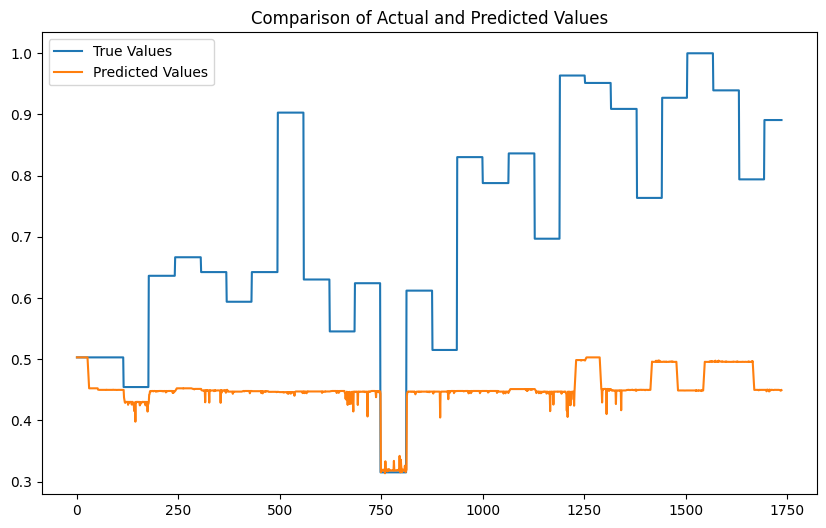

In [ ]:
import matplotlib.pyplot as plt

# Predicting
predicted_values = rf.predict(X_test_reshaped)
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='True Values')
plt.plot(predicted_values, label='Predicted Values')
plt.title('Comparison of Actual and Predicted Values')
plt.legend()
plt.show()

### Evaluating the model
Mean Squared Error (MSE) is ideal for evaluating the Random Forest model in forecasting firm earnings because it penalizes larger errors, enhancing prediction accuracy. Its mathematical properties facilitate optimization and interpretation, while providing a consistent, standard metric for comparing model performance. MSE aligns well with the project's goal of minimizing forecast errors.

In [ ]:
from sklearn.metrics import mean_squared_error

y_pred = rf.predict(X_test_reshaped)
test_loss = mean_squared_error(y_test, y_pred)
print(f'Test Loss: {test_loss}')

Test Loss: 0.09723491972110265


### Hypertuning Parameters
We'd like to try hypertuning the parameters to the original random forest regressor to try to get better results than the previous model. To do this we'd use GridSearchCV.

In [ ]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Create a base model
rf = RandomForestRegressor(random_state=0)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                           cv=3, n_jobs=-1, verbose=2)

# Fit the grid search to the data
grid_search.fit(X_train_reshaped, y_train)

# Get the best parameters
best_params = grid_search.best_params_

# Train the model using the best parameters
rf_best = RandomForestRegressor(**best_params, random_state=0)
rf_best.fit(X_train_reshaped, y_train)

# Make predictions on the test set using the new model
y_pred = rf_best.predict(X_test_reshaped)

Fitting 3 folds for each of 288 candidates, totalling 864 fits
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.0s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.4s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.3s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   4.1s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   2.0s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   2.4s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   4.5s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; tota

Below are the best found parameters and we will use them to train our rf_best model

In [ ]:
# Train the model using the best parameters
rf_best = RandomForestRegressor(**best_params, random_state=0)
rf_best.fit(X_train_reshaped, y_train)
best_params

{'bootstrap': False,
 'max_depth': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 400}

In [ ]:
# Make predictions on the test set using the new model
y_pred = rf_best.predict(X_test_reshaped)

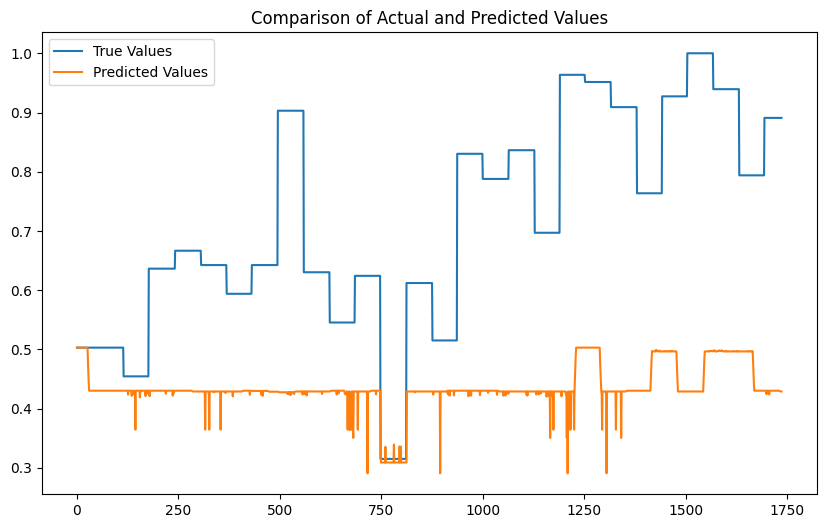

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='True Values')
plt.plot(y_pred, label='Predicted Values')
plt.title('Comparison of Actual and Predicted Values')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error
y_pred = rf_best.predict(X_test_reshaped)
test_loss = mean_squared_error(y_test, y_pred)
print(f'Test Loss: {test_loss}')

Test Loss: 0.10586315977155072


### Random Forest Result Explanation
The Random Forest model may underperform compared to RNNs and XGBoost in this project due to its limited ability to capture temporal dependencies and sequential patterns inherent in financial data. While Random Forests are robust for general prediction tasks, they lack the capability of RNNs to model time series data effectively. Additionally, XGBoost's ability to handle complex feature interactions and non-stationarity in financial metrics provides a significant edge. The averaging nature of Random Forests can also dilute subtle but crucial patterns, leading to less accurate earnings forecasts. We can also notice that hypertuning the parameters can also overfit the model as the second model performs slightly worse than the first one. 

# XGBoost (Hank)

In [ ]:
# import modules
#import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor

import matplotlib.pyplot as plt

In [ ]:
np.random.seed(42)

## Feature extraction for our model

Since our data was accrued from several sources, the history of some metrics is significantly lesser than the others. Most significant is the Equity Ratio which was calculated from Alpha Vantage's Balance Sheet data for Johnson and Johnson. Before training the model I think it is best to make a value judgement on wether attempting to impute such a value is realistic, or if it would be more likely to inject noise


In [ ]:
Number_ER = Features_And_Target_df[Features_And_Target_df['Equity Ratio'].notna()].shape[0]
Number_ER_missing = Features_And_Target_df.shape[0]-Number_ER
print("Number of Equity Ratio Points Missing: ", Number_ER_missing)
print("Number Present :", Number_ER)

Number of Equity Ratio Points Missing:  53
Number Present : 60


With a limited data set and the number of missing data points being roughly equivalent to number present I think it is best to simply omit these features from the model. I do however believe that adding a year's worth of feature's representing our target is worthwhile as it allows our ensemble of predictiors to include how earnings have changed over the prior year, allowing us to better model the data's nature as time series.

In [ ]:
# Drop unimputable Features
Hank_FT_df = Features_And_Target_df.drop(columns = ['totalAssets', 'Equity Ratio'])
# add lagged target as features 
Hank_FT_df['Reported_EPS_lag1'] = Hank_FT_df['Reported EPS'].shift(1)
Hank_FT_df['Reported_EPS_lag2'] = Hank_FT_df['Reported EPS'].shift(2)
Hank_FT_df['Reported_EPS_lag3'] = Hank_FT_df['Reported EPS'].shift(3)
Hank_FT_df['Reported_EPS_lag4'] = Hank_FT_df['Reported EPS'].shift(4)

# Confirm that only lagged columns have missing values
rows_with_missing_values = Hank_FT_df.isnull().any(axis=1).sum()
if rows_with_missing_values != 4:
    print("Unanticipated missing Data Detected")
else:
    Hank_FT_df.dropna(inplace = True)
Hank_FT_df.head()

,Estimated EPS,Reported EPS,geo_mean_Daily_Return_percent_SP_prev_week,geo_mean_Daily_Return_percent_SP_prev_month,geo_mean_Daily_Return_percent_SP_prev_quarter,geo_mean_Daily_Return_percent_VIX_prev_week,geo_mean_Daily_Return_percent_VIX_prev_month,geo_mean_Daily_Return_percent_VIX_prev_quarter,geo_mean_Daily_Return_percent_prev_week,geo_mean_Daily_Return_percent_prev_month,geo_mean_Daily_Return_percent_prev_quarter,geo_mean_volume_prev_quarter,avg_dividend_prev_quarter,Reported_EPS_lag1,Reported_EPS_lag2,Reported_EPS_lag3,Reported_EPS_lag4
Date,,,,,,,,,,,,,,,,,
1997-03-31,0.34,0.34,-0.006978,-0.002175,0.000203,0.031544,0.012011,0.004900,-0.015737,-0.006895,-0.001817,5.163951e+06,0.095,0.21,0.28,0.30,0.30
1997-06-30,0.34,0.34,-0.002531,0.002026,0.002591,0.008545,-0.001616,-0.004182,-0.006602,0.001573,0.001716,4.431570e+06,0.110,0.34,0.21,0.28,0.30
1997-09-30,0.32,0.32,-0.001427,0.002469,0.000629,0.004503,-0.003728,-0.000217,-0.008322,-0.001618,-0.004798,5.598138e+06,0.110,0.34,0.34,0.21,0.28
1997-12-31,0.23,0.24,0.006579,-0.000064,-0.000220,-0.028643,0.004153,0.000736,-0.003061,0.000244,0.000135,4.612048e+06,0.110,0.32,0.34,0.34,0.21
1998-03-31,0.37,0.37,0.000949,0.002400,0.002038,0.026917,0.005382,-0.002972,-0.007959,-0.003035,0.001384,4.256888e+06,0.110,0.24,0.32,0.34,0.34


## Preprocessing 
While PCA is often desirable for decsion tree regressors as a way to reduce the number of features and overall size of the data set, in our case we have a pretty limited history of earnings to actually target. I have elected not to apply PCA in this case, but if I were applying this model to a more data set that had a longer history available I likely would. While we had to drop these features already do to their sparse nature, one way we could reduce the number of featurers is simply by removing total assets and retaining only the equity ratio, as by definition the equity ratio partially encodes this information and is ofter the more useful metric for financial analysis anyway.

I will however be applying a standard scaler to our features as we have a broad range of values ranging from 1e-5 with some of our average returns over the quarter being close to 0 (as you would expect for a stationary process), up to 1e7 for the volume oh shares being traded. In order for our gradient boosting to be effective, and our regressors to not exhibit a strong bias toward one feature it is best that we have them all in a similar range.

We also remove the Expected Earnings  per Share from our features, as we are going to use this to judge the performance of our model compared to traditional methods, and it wouldn't be "Machine learning" if we were training our model on human predictions. In reality, there is an argument to be made that incorporating the predictions of a firm's traditional analysis may have value to that firm, but for the sake of this project it is much better used as performance benchmark.

In [ ]:
# isolate target
y_hb = Hank_FT_df['Reported EPS']
y_hb = pd.DataFrame(y_hb.values, columns=[y_hb.name], index = y_hb.index)

# save analyst predictions 
analyst_pred_EPS = Hank_FT_df['Estimated EPS']
# isolate features 
X_hb = Hank_FT_df.drop(columns = ['Reported EPS','Estimated EPS'])

SS_hb = StandardScaler()

SS_pred_hb = StandardScaler()

X_hb_std_df = pd.DataFrame(SS_hb.fit_transform(X_hb),
                         columns=X_hb.columns, index=X_hb.index)

y_hb_std_df = pd.DataFrame(SS_pred_hb.fit_transform(y_hb),
                         columns=y_hb.columns, index=y_hb.index)

## Basic 80/20 split repeated recursively to get a test set and validation set

# Split dataset up
tst_split_indx = int(X_hb.shape[0]*0.8)
trn_val_split_indx = int(tst_split_indx *0.8)

# get test set
X_hb_test = X_hb_std_df.iloc[tst_split_indx:]
y_hb_test = y_hb_std_df.iloc[tst_split_indx:]

X_hb_lessTst = X_hb_std_df.iloc[:tst_split_indx]
y_hb_lessTst = y_hb_std_df.iloc[:tst_split_indx]

# get val set
X_hb_val = X_hb_lessTst.iloc[trn_val_split_indx:]
y_hb_val = y_hb_lessTst.iloc[trn_val_split_indx:]

# get train set
X_hb_train = X_hb_lessTst.iloc[:trn_val_split_indx]
y_hb_train = y_hb_lessTst.iloc[:trn_val_split_indx]


## Fit Model

In [ ]:
y_hb_std_df.values.shape

(109, 1)

## using grid search to get some good starting parameters
In order



In [ ]:
X_hb_arr = X_hb_std_df.values
y_hb_arr = y_hb_std_df.values.ravel()

tscv_hb = TimeSeriesSplit(n_splits=3)

param_grid_hb = {
    'n_estimators': [50, 100, 150, 200], # boosting stages
    'learning_rate': [ 0.001, 0.01, 0.1, 1], # Rate at which tree's contribution diminishes
    'max_depth': [2, 3, 5, 10],  # number of nodes in tree
    'subsample': [0.8, 1.0],
    'min_samples_split': [2, 3, 4, 6] # minimum number of samples require to split a node
    
}

# Grid Search
model_hb = GradientBoostingRegressor(warm_start=False, random_state= 42)
grid_search_hb = GridSearchCV(estimator=model_hb, param_grid=param_grid_hb, cv=tscv_hb, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_hb.fit(X_hb_arr, y_hb_arr)

best_init_params_hb = grid_search_hb.best_params_

In [ ]:
print("Best Parameters found by grid search :", best_init_params_hb)
# save best model from grid search
best_GBRT_hb = grid_search_hb.best_estimator_
print(" ")

# Train Model on training set
best_GBRT_hb.fit(X_hb_train.values, y_hb_train.values.ravel())

y_val_hb_pred = best_GBRT_hb.predict(X_hb_val.values)

best_GBRT_hb_MSE = mean_squared_error(y_pred=y_val_hb_pred, y_true=y_hb_val.values.ravel() )

print("The Tuned Model's MSE on the validation data is : ", best_GBRT_hb_MSE)
#best_GBRT_hb.score(X_hb_val.values,y_hb_val.values.ravel())

y_train_hb_pred = best_GBRT_hb.predict(X_hb_train.values)
best_GBRT_hb_MSE_inSamp = mean_squared_error(y_pred=y_train_hb_pred, y_true= y_hb_train.values.ravel() )
print("The Tuned Model's MSE on the Training data is : ", best_GBRT_hb_MSE_inSamp)

Best Parameters found by grid search : {'learning_rate': 1, 'max_depth': 3, 'min_samples_split': 6, 'n_estimators': 100, 'subsample': 1.0}
 
The Tuned Model's MSE on the validation data is :  0.2024854203009841
The Tuned Model's MSE on the Training data is :  2.048228459411634e-16


Clearly this model is over tuned, which is expected for a Gradient Boosted Regressor. We can use the staged predicts to iterate over our 100 estimators to we if we can find a number of trees which is less likely to overfit

In [ ]:
errors_hb = [mean_squared_error(y_hb_val.values.ravel(), y_pred)
          for y_pred in best_GBRT_hb.staged_predict(X_hb_val)]
errors_hb[:10]

S:\Documents\Coursework\521-Final-Project\env\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(


[0.25217010938584244,
 0.1796457432879121,
 0.22524998430277002,
 0.22144432517572965,
 0.2283235097221331,
 0.21785526137643332,
 0.21714288001699045,
 0.1968422479988887,
 0.19849391447634324,
 0.19788087239413546]

Already we can see that even two estimators outperforms our overfitted model on the validation data. We can take the minimum error and use this to select the proper number of trees.

In [ ]:
best_MSE_hb = np.min(errors_hb)
best_n_estimators_hb = np.argmin(errors_hb)+1
print("min MSE: {:.4f}, number of trees: {}"
      .format(best_MSE_hb, best_n_estimators_hb))

min MSE: 0.1796, number of trees: 2


We find that the number of trees that best work for minimizing performance on data set is acutally only 2 estimators. However is still has MSE that is orders of magnitude than our earlier model. We should train a model using our tuned parameters and these estimators to test this.

In [ ]:
# update param dict
tuned_estimator_params_hb = best_init_params_hb
tuned_estimator_params_hb['n_estimators'] = best_n_estimators_hb
# create new model and use tuned params
tuned_GBRT_hb = GradientBoostingRegressor(warm_start=False, random_state= 42)
tuned_GBRT_hb.set_params(**tuned_estimator_params_hb)
# fit tuned model
tuned_GBRT_hb.fit(X_hb_train.values, y_hb_train.values.ravel())

#
y_val_hb_pred = tuned_GBRT_hb.predict(X_hb_val.values)

tuned_GBRT_hb_MSEoutSamp = mean_squared_error(y_pred=y_val_hb_pred, y_true=y_hb_val.values.ravel() )

print("The final Model's MSE on the validation data is : ", tuned_GBRT_hb_MSEoutSamp)
#best_GBRT_hb.score(X_hb_val.values,y_hb_val.values.ravel())

y_train_hb_pred = tuned_GBRT_hb.predict(X_hb_train.values)

tuned_GBRT_hb_MSE_inSamp = mean_squared_error(y_pred=y_train_hb_pred, y_true= y_hb_train.values.ravel() )
print("The final Model's MSE on the Training data is : ", best_GBRT_hb_MSE_inSamp)
#tuned_model_hb.get_params()

The final Model's MSE on the validation data is :  0.1796457432879121
The final Model's MSE on the Training data is :  2.048228459411634e-16


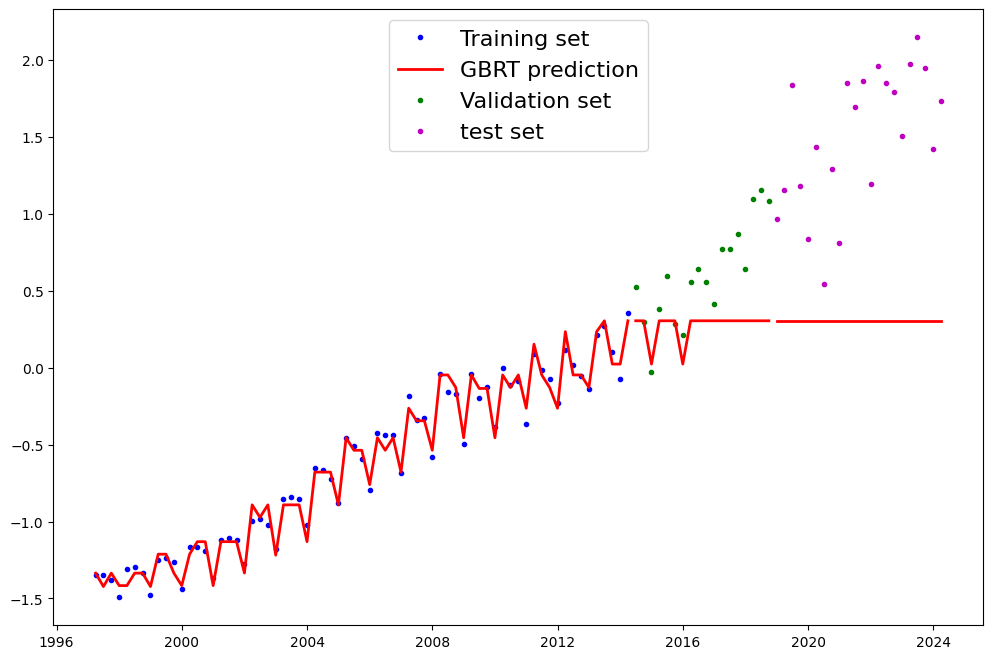

In [ ]:
plt.figure(figsize=(12,8))

y_val_hb_pred_df = pd.Series(y_val_hb_pred, index= y_hb_val.index)
y_train_hb_pred_df = pd.Series(y_train_hb_pred, index= y_hb_train.index)
y_test_hb_pred = tuned_GBRT_hb.predict(X_hb_test.values)
y_test_hb_pred_df = pd.Series(y_test_hb_pred, index= y_hb_test.index)


plt.plot( y_hb_train, "b.", label="Training set")
plt.plot(y_train_hb_pred_df, "r-", linewidth=2, label="GBRT prediction")

plt.plot( y_hb_val, "g.", label="Validation set")
plt.plot(y_val_hb_pred_df, "r-", linewidth=2, )

plt.plot( y_hb_test, "m.", label="test set")
plt.legend(loc="upper center", fontsize=16)
plt.plot(y_test_hb_pred_df, "r-", linewidth=2,)
plt.show()

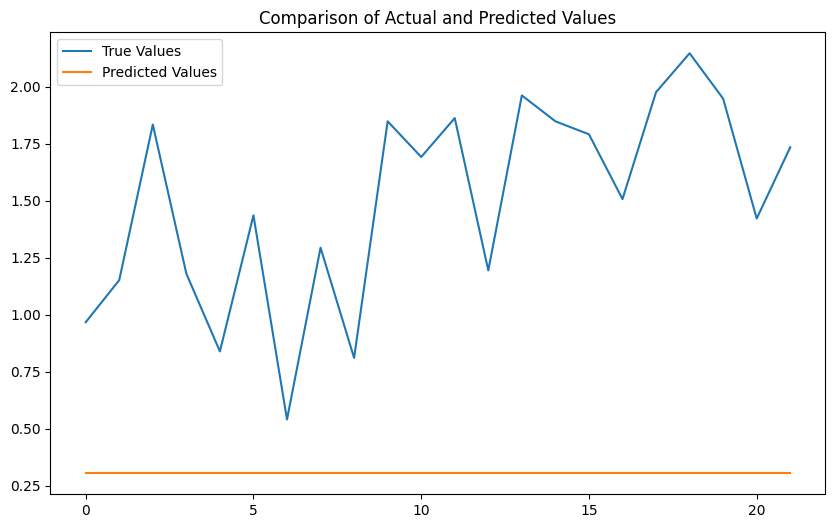

In [ ]:
# Plotting
predicted_values = tuned_GBRT_hb.predict(X_hb_test.values)
predicted_values
plt.figure(figsize=(10, 6))
plt.plot(y_hb_test.values, label='True Values')
plt.plot(predicted_values, label='Predicted Values')
plt.title('Comparison of Actual and Predicted Values')
plt.legend()
plt.show()

## Fitted Model and Results
    - Report on hyper parameters
    - Report on fit quality
    - Ideas on improvement if the model was continued to be

# Support Vector Machines (Bhavesh)

# Kmeans Regimes + Markov Chain (Kevin)




## Why this model for this problem


### Why Use K-means Clustering?

- **Pattern Discovery**: K-means helps us find patterns or groups in the financial data. Each group, or cluster, represents a specific type of market behavior or financial condition.
- **Manage Complexity**: Financial data can be complex and varied. Clustering simplifies this by breaking down the entire dataset into a few similar groups, making it easier to analyze and understand.

### Why Use Markov Chains?

- **Predict Transitions**: Once we have identified these groups with K-means, Markov chains help us predict how likely it is to move from one group to another over time.
- **Capture Dynamics**: Financial markets are dynamic; they change frequently. Markov chains are good at modeling these changes, especially when we assume that the future state depends mostly on the current state and not much else.

### Combining Both Models

- **Comprehensive Approach**: By combining both methods, we first simplify the complex data into clusters and then model how these clusters change over time. This two-step approach gives us a clear and dynamic picture of what might happen in the future. 
- **Better EPS Prediction**: Since EPS can be influenced by various market conditions represented by different clusters, predicting how these conditions change helps us forecast EPS more accurately.


## Model Architecture


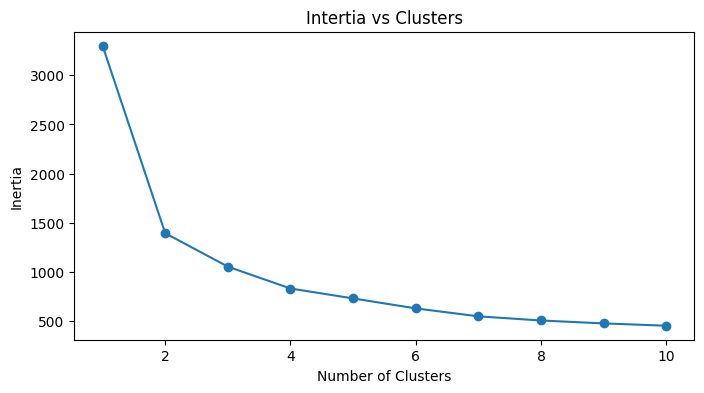

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt



# Create a function that plots our Intertia vs clusters for the elbow method
def find_optimal_clusters(data, max_k):
    inertia = []
    for k in range(1, max_k+1):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(data)
        inertia.append(kmeans.inertia_)
    
    plt.figure(figsize=(8, 4))
    plt.plot(range(1, max_k+1), inertia, marker='o')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')
    plt.title('Intertia vs Clusters')
    plt.show()

find_optimal_clusters(data_scaled, max_k=10)


Our optimal number of clusters is around 4. Let's visualize the data distribution across the clusters.

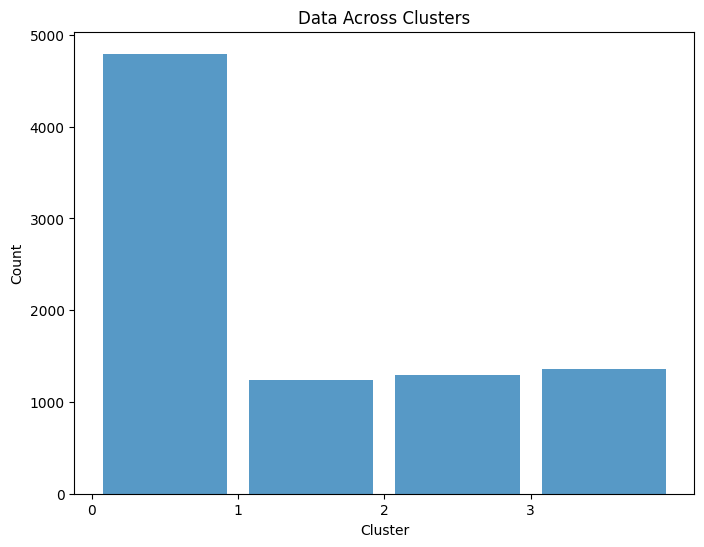

In [ ]:

# Our best clusters is 4
num_clusters = 4  

kmeans = KMeans(n_clusters=num_clusters, random_state=42)
regimes = kmeans.fit_predict(data_scaled)

merged_df['Cluster_Labels'] = regimes

# Visualize the distribution of data across clusters
plt.figure(figsize=(8, 6))
plt.hist(regimes, bins=range(num_clusters+1), alpha=0.75, rwidth=0.85)
plt.title('Data Across Clusters')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.xticks(ticks=np.arange(num_clusters))
plt.show()

### Markov Chain Probability Matrix

Now Let's create a Markov chain probability matrix using our k means clusters.

### 

Transition Prob Matrix:
[[9.99374348e-01 0.00000000e+00 6.25651721e-04 0.00000000e+00]
 [0.00000000e+00 9.99194198e-01 0.00000000e+00 8.05801773e-04]
 [1.54440154e-03 0.00000000e+00 9.96911197e-01 1.54440154e-03]
 [0.00000000e+00 1.47710487e-03 7.38552437e-04 9.97784343e-01]]


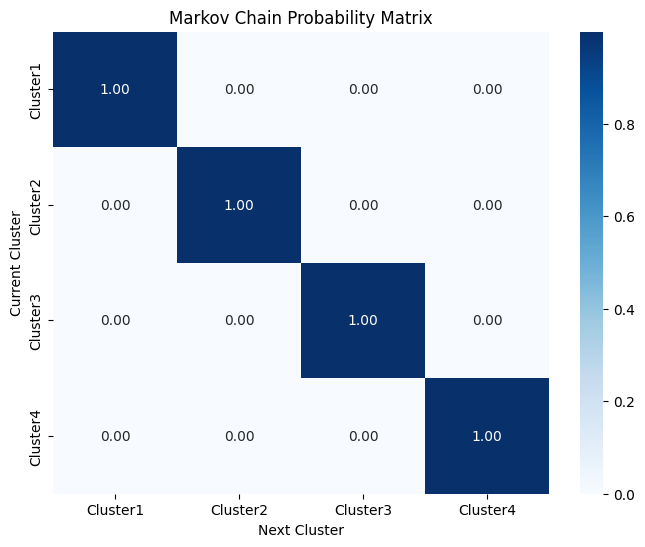

In [ ]:
import numpy as np


num_clusters = 4  # 

# a transition matrix of size (num_clusters x num_clusters) with zeros
transition_matrix = np.zeros((num_clusters, num_clusters))

# calc transitions from each cluster to another
for i in range(len(regimes) - 1):
    current_regime = regimes[i]
    next_regime = regimes[i + 1]
    transition_matrix[current_regime][next_regime] += 1

# we convert counts to probabilities and divide each row by the sum of elements in that row to get probability distribution
transition_matrix = np.array([row / row.sum() if row.sum() != 0 else row for row in transition_matrix])

# we print our transition matrix
print("Transition Prob Matrix:")
print(transition_matrix)

# Visual representation of our matrix
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(transition_matrix, annot=True, fmt=".2f", cmap="Blues", xticklabels=["Cluster1", "Cluster2", "Cluster3", "Cluster4"], yticklabels=["Cluster1", "Cluster2", "Cluster3", "Cluster4"])
plt.title('Markov Chain Probability Matrix')
plt.xlabel('Next Cluster')
plt.ylabel('Current Cluster')
plt.show()

Our probability matrix is very static, if we start on regime 1, we stay on the first regime, this the dynamic predictive power is very low. Let's visualize what happens if we start on the first cluster and simulate our markov chain into the future.

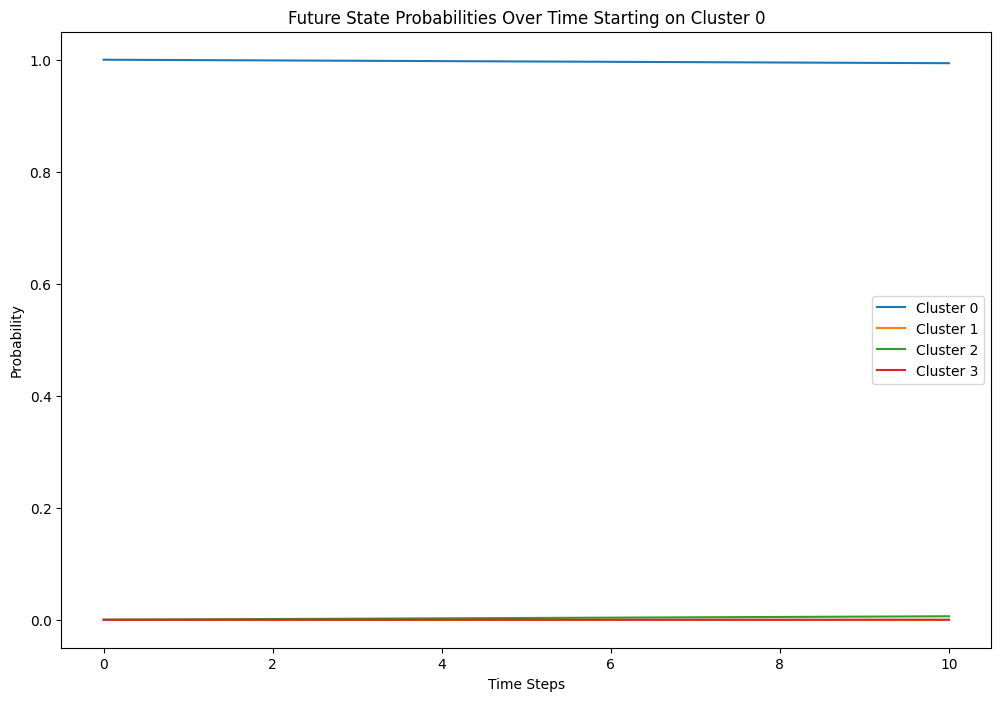

In [ ]:
import numpy as np


num_clusters = 4  # Number of clusters or states in the Markov chain
num_steps = 10    # We'll start with 10 steps

# predicts next state given current state distribution
def predict_next_state(current_state_prob, transition_matrix):
    """
    Multiply the current state probability distribution by the transition matrix
    to get the next state distribution.
    """
    return np.dot(current_state_prob, transition_matrix)

# simulates multiple steps in the future
def simulate_markov_chain(start_state, transition_matrix, num_steps):
    """
    Simulate a number of steps in a Markov chain given a start state and a transition matrix.
    """
    # set the current state probability distribution
    current_state_prob = np.zeros(num_clusters)
    current_state_prob[start_state] = 1
    
    # stores the state probabilities over time
    future_states = [current_state_prob]
    
    for _ in range(num_steps):
        next_state_prob = predict_next_state(current_state_prob, transition_matrix)
        future_states.append(next_state_prob)
        current_state_prob = next_state_prob
    
    return np.array(future_states)

# let's say we start on cluster 0
current_regime = 0

# simulate the Markov chain from the current regime
future_states = simulate_markov_chain(current_regime, transition_matrix, num_steps)

# Visualize our Regime Changes
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
for i in range(num_clusters):
    plt.plot(future_states[:, i], label=f'Cluster {i}')

plt.title('Future State Probabilities Over Time Starting on Cluster 0')
plt.xlabel('Time Steps')
plt.ylabel('Probability')
plt.legend()
plt.show()

As you can see, if we start on cluster 0, we're almost gauranteed to stay on that regime. There's no dyanmacism to our model. Let's look at our model's composition. Which features make up our clusters?

Centroids of each cluster:
   Daily_Return_percent_SP  Daily_Return_percent_VIX  Dividends        Volume  \
0                 0.000753                 -0.005192   0.547532  1.371322e+07   
1                 0.000174                 -0.003738   0.794248  7.198530e+06   
2                 0.000250                  0.000394   0.178679  6.471742e+06   
3                 0.000224                 -0.008747   1.066731  7.745934e+06   

   Daily_Return_percent  Estimated EPS  Reported EPS   totalAssets  \
0              0.003116       1.201008      1.239167  1.114483e+11   
1             -0.000521       1.651483      1.698539  1.203087e+11   
2             -0.002162       1.120000      1.150000  1.036550e+11   
3             -0.000354       2.268986      2.396924  1.402400e+11   

   Equity Ratio  Cluster_Labels  
0      0.182466    2.000000e+00  
1      0.137961    2.974802e+00  
2      0.148377    1.698641e-14  
3      0.147584    1.000000e+00  


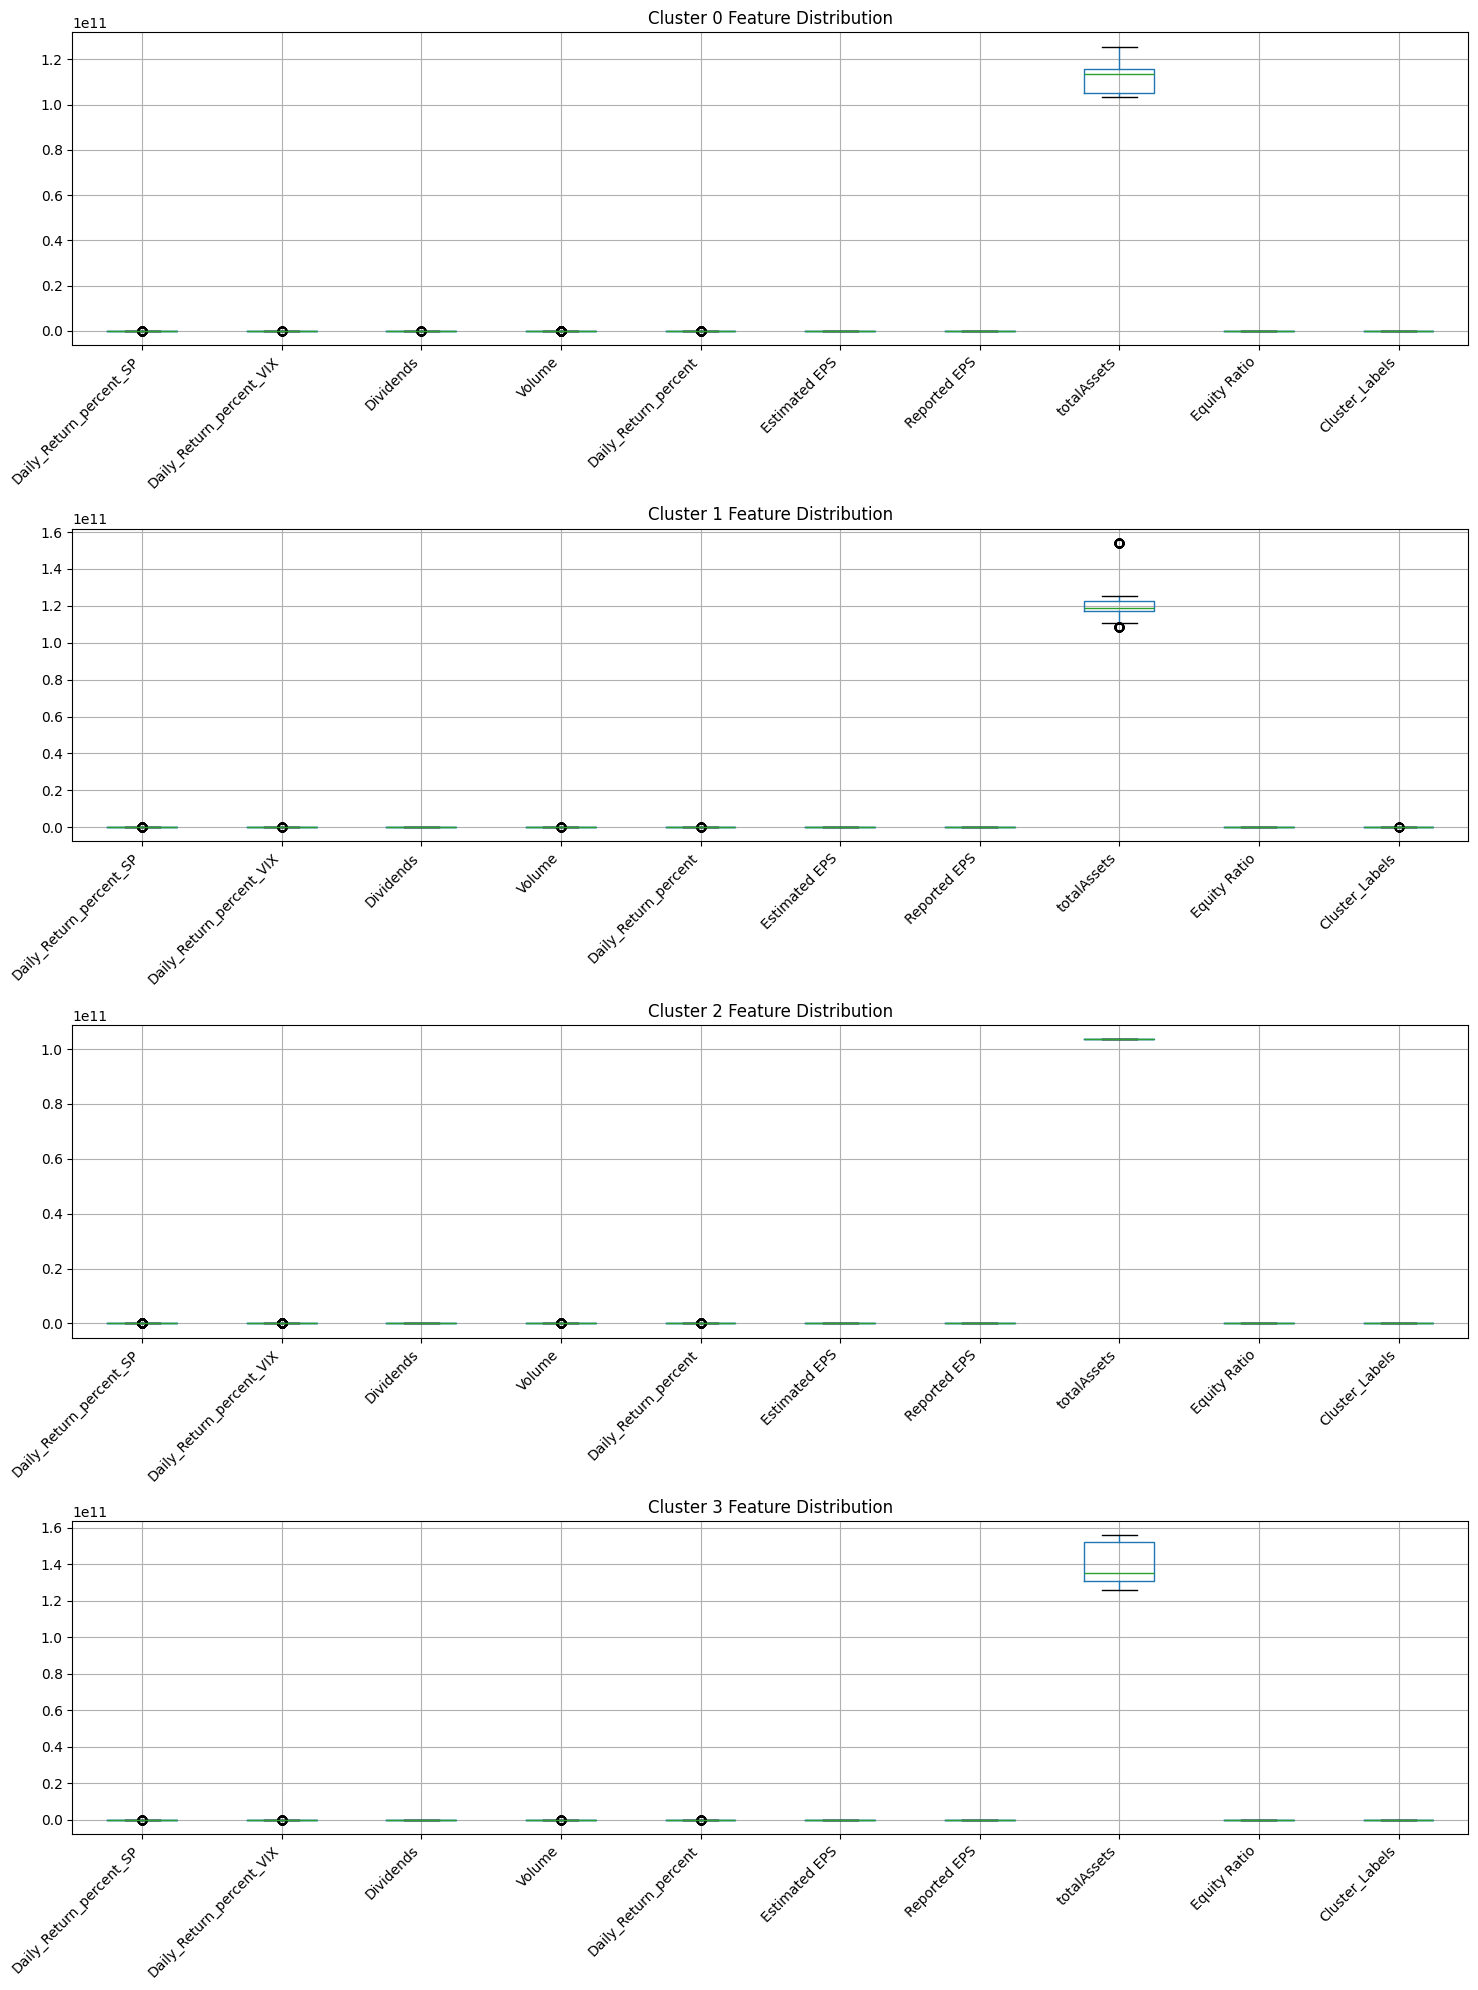

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans


features = merged_df.columns[:-1]  

# make standard scaler
scaler = StandardScaler()
data_scaled = scaler.fit_transform(merged_df[features])

# apply K-means clustering
num_clusters = 4  
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
clusters = kmeans.fit_predict(data_scaled)

# add cluster label
merged_df['Cluster'] = clusters

# calculate centroids of each cluster
centroids = kmeans.cluster_centers_

# ensure 'features' matches the columns used for scaling
centroids_inverse_transformed = scaler.inverse_transform(centroids)
centroids_df = pd.DataFrame(centroids_inverse_transformed, columns=features)
print("Centroids of each cluster:")
print(centroids_df)

# visualize Feature Distributions in Each Cluster
fig, axs = plt.subplots(num_clusters, figsize=(15, num_clusters*5))
for i in range(num_clusters):
    cluster_data = merged_df[merged_df['Cluster'] == i]
    cluster_data[features].drop('Cluster', axis=1, errors='ignore').boxplot(ax=axs[i])
    axs[i].set_title(f'Cluster {i} Feature Distribution')
    axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()


## Model Evaluation and Results



### Model Summary:

1. **K-means Clustering**
   - **Objective**: Segregate the dataset into distinct regimes based on our financial features.
   - **Result**: Clusters were heavily influenced by the 'total_assets' feature, with other features contributing minimally. This indicates that the clustering might be skewed by the dominance of this particular feature due to its scale or variance compared to other variables in the dataset.

2. **Transition Matrix via Markov Chain**
   - **Objective**: Model transitions between different financial regimes identified by K-means to predict future states for time-series.
   - **Result**: The transition probability matrix showed extremely high probabilities of remaining in the current state (close to or above 99% for staying in the same cluster). Almost no regime changes over time. This means we have a very stable and static model with little dynamic transition between states.

### Analysis of Results:

- **Feature Dominance**: The overwhelming influence of 'total_assets' suggests that either this feature is disproportionately scaling compared to others or it naturally varies less over time, leading to static cluster assignments. This has potentially masked more subtle variations in other financial metrics that could be more helpful for predicting EPS.

- **Limited Dynamics Captured**: The high stability observed in the transition probabilities points to either an inherently stable dataset or a model that is unable to capture the fine triggers required to detect regime changes. Financial data is often very subtle that simple clustering may not be able to capture.

- **Predictive Power Concerns**: Given the lack of transitions between states, using this model to forecast future EPS would likely result in static predictions, a flat line for EPS, or a dummy model. This model fails to provide useful predictions for EPS.

### Recommendations for Improvement:

1. **Data Preprocessing**:
    - Re-examine and possibly rescale or normalize the features so that each contributes equally to the distance calculations in K-means.
    - Consider transforming features to better capture changes (e.g., using logarithmic scales or differences instead of absolute values).

2. **Feature Engineering**:
    - Increase the number of features by incorporating additional data or deriving new metrics from existing data (e.g., ratios, year-over-year changes). We may need much more than 10 features for effective K-means clustering.

3. **Model Exploration**:
    - Consider other models more suited to time-series data, such as our models above.

4. **Extend Dataset**:
    - If possible, incorporate more historical data to capture a broader range of economic cycles and market conditions. We only have 10 years of data.
    - Integrate external data sources that could impact EPS for more indicators or features.

### Conclusion:

The current model setup provides an interesting case for the limitations in our its ability to dynamically predict shifts in earnings per share. We see the restrictions of our model, specifically we've learned a lot in what could be done to make it better.

## Why this model for this problem
Support Vector Machines (SVMs) offer a compelling approach for forecasting future firm earnings based on financial data due to their robustness in handling high-dimensional datasets and ability to capture complex relationships between features. In financial forecasting, where datasets often contain numerous predictors and intricate patterns, SVMs excel at identifying the optimal decision boundary that separates different market regimes or states, thereby enabling accurate prediction of earnings trends. Additionally, SVMs can effectively handle both linear and non-linear relationships through the use of appropriate kernel functions, making them versatile for capturing the nuanced dynamics of financial markets. Their ability to generalize well to unseen data further enhances their utility in this context, as it ensures reliable predictions even in the face of changing market conditions.

## Model Architecture
SVM aims to find the optimal hyperplane that separates data classes while maximizing margin. It utilizes support vectors and kernel functions to handle non-linear relationships efficiently. Regularization prevents overfitting, and the decision function assigns new data points to classes based on their position relative to the hyperplane.

In [ ]:
from sklearn.svm import SVR

# Create a Support Vector Regressor
svr = SVR(kernel='rbf', C=1.0, epsilon=0.2)

# Train the model
svr.fit(X_train_reshaped, y_train)

# Make predictions on the test set
y_pred = svr.predict(X_test_reshaped)

We'd like to plot this data against the original test values to get a visual representation of how it performed.

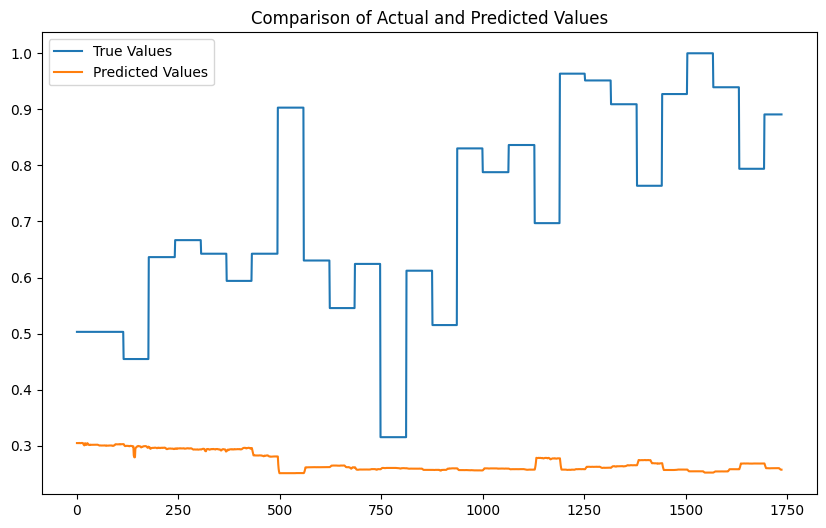

In [ ]:
import matplotlib.pyplot as plt

# Predicting
predicted_values = svr.predict(X_test_reshaped)
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='True Values')
plt.plot(predicted_values, label='Predicted Values')
plt.title('Comparison of Actual and Predicted Values')
plt.legend()
plt.show()

### Evaluating the model
We would like to use the Mean squared Error to evaluate this model and better compare it to the other models.

In [ ]:
from sklearn.metrics import mean_squared_error
# Make predictions on the test set
y_pred = svr.predict(X_test_reshaped)
# Calculate the mean squared error
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error: ", mse)

Mean Squared Error:  0.23455574605030258


### Hypertuning Parameters
We'd like to make this model more robust and ensure that the parameters are well suited for this specific usecase. We will use GridSearchCV to hypertune the parameters inorder to get a better prediction

In [ ]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'C': [0.1, 1, 10, 100],
    'epsilon': [0.1, 0.2, 0.3, 0.4, 0.5],
    'kernel': ['rbf', 'linear', 'poly']
}

# Create a Support Vector Regressor
svr = SVR()

# Create GridSearchCV object
grid_search = GridSearchCV(svr, param_grid, cv=5, scoring='neg_mean_squared_error')

# Fit the model
grid_search.fit(X_train_reshaped, y_train)

# Get the best parameters
best_params = grid_search.best_params_

print("Best parameters: ", best_params)

# Train the model with the best parameters
svr_best = SVR(**best_params)
svr_best.fit(X_train_reshaped, y_train)

# Make predictions on the test set
y_pred = svr_best.predict(X_test_reshaped)

Best parameters:  {'C': 0.1, 'epsilon': 0.1, 'kernel': 'poly'}


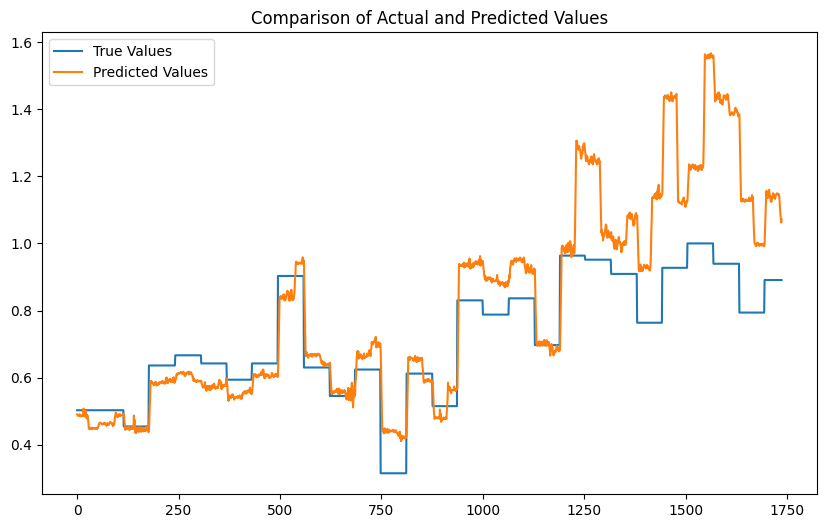

In [ ]:
import matplotlib.pyplot as plt

# Predicting
predicted_values = svr_best.predict(X_test_reshaped)
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='True Values')
plt.plot(predicted_values, label='Predicted Values')
plt.title('Comparison of Actual and Predicted Values')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error
# Make predictions on the test set
y_pred = svr_best.predict(X_test_reshaped)
# Calculate the mean squared error
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error: ", mse)

Mean Squared Error:  0.03431552704503399


### SVM Result Explanation
The SVM branch with parameters {'C': 0.1, 'epsilon': 0.1, 'kernel': 'poly'} likely performed well due to its choice of parameters tailored to the problem. A polynomial kernel might have effectively captured the non-linear relationships in the data, while a smaller regularization parameter (C) and epsilon might have helped in achieving a smoother fit with lesser error. Conversely, SVM with {'kernel': 'rbf', 'C': 1.0, 'epsilon': 0.2} exhibited higher Mean Squared Error (MSE), potentially due to overfitting or less suitable parameter choices for the data, particularly with the radial basis function kernel, which might have been sensitive to the given C and epsilon values. Overall the SVM performed well due to its ability to effectively handle complex relationships in the financial data and generalize well to unseen data.

### Why this model for this problem
The reason why Random Forest is effective for this project, which involves predicting the estimated Earnings Per Share (EPS), includes:

Overfitting Prevention: Random Forest helps to prevent overfitting, a common problem in machine learning where a model performs well on training data but poorly on unseen data. This is achieved by averaging the predictions from multiple decision trees.

Handling High Dimensionality: Random Forest can effectively handle datasets with a large number of features. It does this by randomly selecting a subset of features at each node when building the trees.

Interpretability: Random Forest provides a measure of feature importance, which can help in understanding which features are most influential in predicting the EPS.

Non-linearity: Financial data often exhibit non-linear relationships. Random Forest does not make any assumptions about the underlying relationships between features and the target variable, making it a suitable choice for this project.

Robustness to Outliers: Random Forest is less sensitive to outliers in the data. This is particularly useful in financial data, which can often contain outliers due to sudden market changes.

### Reshaping data
X_train.reshape(X_train.shape[0], -1) and X_test_reshaped = X_test.reshape(X_test.shape[0], -1) reshapes X_train into a two-dimensional array where the number of rows is the same as in the original X_train array, and the number of columns is such that the total number of elements in the array remains the same. This is to fine tune the data so it can be inputted into the RandomForestRegressor.

In [84]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Create a Random Forest Regressor
rf = RandomForestRegressor(n_estimators=200, random_state=0)

# Train the model
# Reshape the input data
X_train_reshaped = X_train.reshape(X_train.shape[0], -1)
X_test_reshaped = X_test.reshape(X_test.shape[0], -1)

# Train the model
rf.fit(X_train_reshaped, y_train)

# Make predictions on the test set
y_pred = rf.predict(X_test_reshaped)

We'd like to plot this data against the original test values to get a visual representation of how it performed.

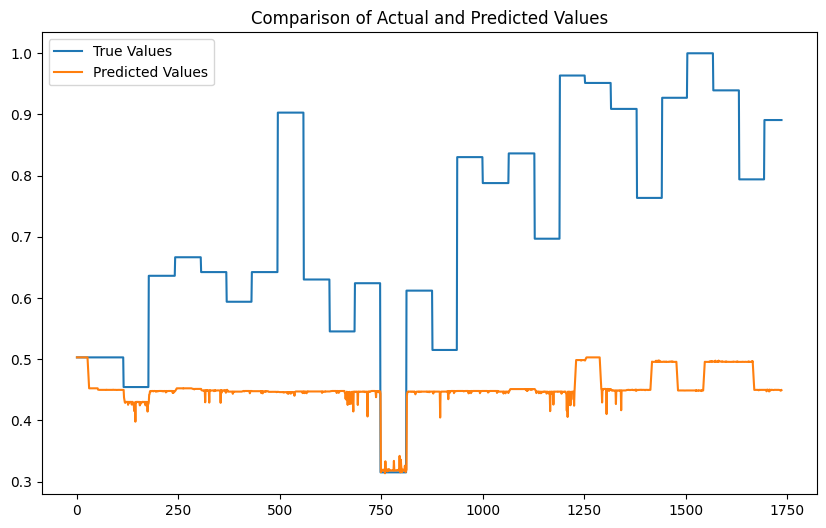

In [85]:
import matplotlib.pyplot as plt

# Predicting
predicted_values = rf.predict(X_test_reshaped)
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='True Values')
plt.plot(predicted_values, label='Predicted Values')
plt.title('Comparison of Actual and Predicted Values')
plt.legend()
plt.show()

### Evaluating the model
Mean Squared Error (MSE) is ideal for evaluating the Random Forest model in forecasting firm earnings because it penalizes larger errors, enhancing prediction accuracy. Its mathematical properties facilitate optimization and interpretation, while providing a consistent, standard metric for comparing model performance. MSE aligns well with the project's goal of minimizing forecast errors.

In [86]:
from sklearn.metrics import mean_squared_error

y_pred = rf.predict(X_test_reshaped)
test_loss = mean_squared_error(y_test, y_pred)
print(f'Test Loss: {test_loss}')

Test Loss: 0.09723491972110265


### Hypertuning Parameters
We'd like to try hypertuning the parameters to the original random forest regressor to try to get better results than the previous model. To do this we'd use GridSearchCV.

In [87]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Create a base model
rf = RandomForestRegressor(random_state=0)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                           cv=3, n_jobs=-1, verbose=2)

# Fit the grid search to the data
grid_search.fit(X_train_reshaped, y_train)

# Get the best parameters
best_params = grid_search.best_params_

# Train the model using the best parameters
rf_best = RandomForestRegressor(**best_params, random_state=0)
rf_best.fit(X_train_reshaped, y_train)

# Make predictions on the test set using the new model
y_pred = rf_best.predict(X_test_reshaped)

Fitting 3 folds for each of 288 candidates, totalling 864 fits


[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.5s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.8s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   3.0s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   4.8s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   2.5s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   2.2s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   5.1s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   2.2s
[CV] END bootstrap=True, max_depth=None, min_sam

KeyboardInterrupt: 

Below are the best found parameters and we will use them to train our rf_best model

In [ ]:
# Train the model using the best parameters
rf_best = RandomForestRegressor(**best_params, random_state=0)
rf_best.fit(X_train_reshaped, y_train)
best_params

{'bootstrap': False,
 'max_depth': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 400}

In [ ]:
# Make predictions on the test set using the new model
y_pred = rf_best.predict(X_test_reshaped)

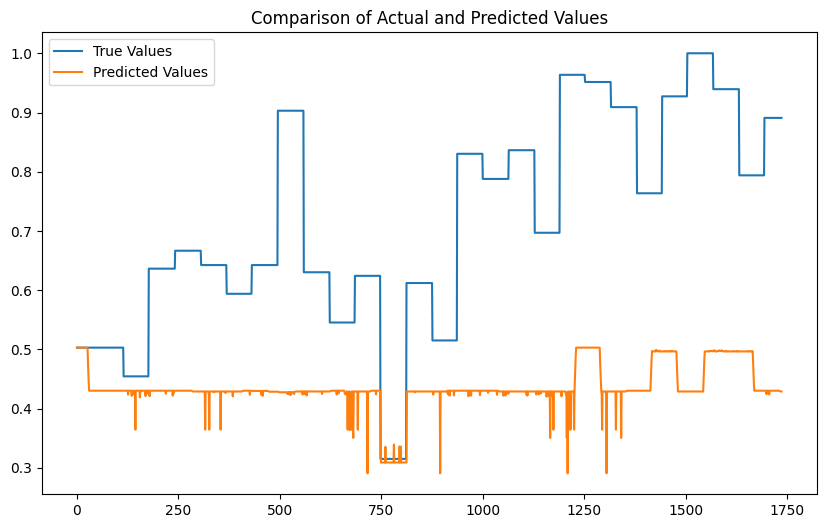

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='True Values')
plt.plot(y_pred, label='Predicted Values')
plt.title('Comparison of Actual and Predicted Values')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error
y_pred = rf_best.predict(X_test_reshaped)
test_loss = mean_squared_error(y_test, y_pred)
print(f'Test Loss: {test_loss}')

Test Loss: 0.10586315977155072


### Random Forest Result Explanation
The Random Forest model may underperform compared to RNNs and XGBoost in this project due to its limited ability to capture temporal dependencies and sequential patterns inherent in financial data. While Random Forests are robust for general prediction tasks, they lack the capability of RNNs to model time series data effectively. Additionally, XGBoost's ability to handle complex feature interactions and non-stationarity in financial metrics provides a significant edge. The averaging nature of Random Forests can also dilute subtle but crucial patterns, leading to less accurate earnings forecasts. We can also notice that hypertuning the parameters can also overfit the model as the second model performs slightly worse than the first one. 

# Vanila Neural Network (Bhavesh)

### Why this model for this problem
A Vanilla Neural Network (VNN) can effectively forecast firm earnings by leveraging its capacity to capture complex non-linear relationships present in financial data. Through hierarchical feature representations and non-linear mapping, VNNs adapt to historical data during training, enabling accurate predictions about future earnings. Techniques like regularization prevent overfitting, ensuring generalization to unseen data. With flexible architectures, VNNs can be tailored to the specific characteristics of the dataset, optimizing performance for the forecasting task at hand.

### What is the model archetecture
The model architecture utilizes a Vanilla Neural Network (VNN) implemented using TensorFlow's Keras API. It comprises three fully connected (Dense) layers. The input layer consists of 50 neurons with Rectified Linear Unit (ReLU) activation, followed by a dropout layer with a dropout rate of 0.2 to prevent overfitting. The second hidden layer also consists of 50 neurons with ReLU activation, followed by another dropout layer. The output layer consists of a single neuron, assuming a single output. The input shape is determined by the number of timesteps (n_steps) multiplied by the number of features in the dataset (n_features). The model structure is summarized using the `summary()` function to verify its configuration and parameter count.

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

n_steps = 4  # This should match the number of timesteps you decided to use in your sequences
n_features = merged_df.shape[1]  # Number of features in your dataset

# Define the vanilla neural network model
model = Sequential([
    Dense(50, activation='relu', input_shape=(n_steps * n_features,)),
    Dropout(0.2),
    Dense(50, activation='relu'),
    Dropout(0.2),
    Dense(1)  # Output layer - assumes a single output
])

# Display model summary to verify its structure
model.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_27 (Dense)                │ (None, 50)             │         1,850 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,451 (17.39 KB)

 Trainable params: 4,451 (17.39 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 292us/step - loss: 0.0078 
Epoch 2/200
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step - loss: 0.0012
Epoch 3/200
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 372us/step - loss: 7.4028e-04
Epoch 4/200
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step - loss: 6.2820e-04
Epoch 5/200
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step - loss: 5.6504e-04
Epoch 6/200
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step - loss: 5.0351e-04
Epoch 7/200
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 281us/step - loss: 3.9988e-04
Epoch 8/200
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 267us/step - loss: 4.2298e-04
Epoch 9/200
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 401us/step - loss: 3.3444e-04
Epoch 10/200
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 283us/step - loss: 4.0682e-04
Epoch 11/200
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 273us/step - loss: 5.3049e-04
Epoch 12/200
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step - loss: 3.5396e-04
Epoch 13/200
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step - loss: 3.7692e-04
Epoch 14/200
218/218 ━━━━━━━━━━━━━━━━━━━━

### Why use SGD Optimizer
Using Stochastic Gradient Descent (SGD) optimizer for this Vanilla Neural Network (VNN) is advantageous due to its computational efficiency, scalability to large datasets, and flexibility in hyperparameter tuning. SGD introduces randomness, aiding generalization and preventing overfitting. It converges to global minima with appropriate tuning and offers interpretability, facilitating model development and debugging. Overall, SGD optimizes training efficiency and enhances the VNN's performance in forecasting firm earnings.

In [ ]:

# Reshape the input data
X_train_reshaped = X_train.reshape(X_train.shape[0], -1)
X_test_reshaped = X_test.reshape(X_test.shape[0], -1)

# Train the model
sgd_optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
model.compile(optimizer=sgd_optimizer, loss='mean_squared_error')
model.fit(X_train_reshaped, y_train, epochs=200, batch_size=32)

# Make predictions on the test set
y_pred = model.predict(X_test_reshaped)

Epoch 1/200
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 275us/step - loss: 1.9652e-04
Epoch 2/200
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 390us/step - loss: 1.5944e-04
Epoch 3/200
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 235us/step - loss: 1.5680e-04
Epoch 4/200
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 244us/step - loss: 1.7073e-04
Epoch 5/200
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 258us/step - loss: 1.8196e-04
Epoch 6/200
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 244us/step - loss: 1.6397e-04
Epoch 7/200
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 387us/step - loss: 1.8301e-04
Epoch 8/200
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 238us/step - loss: 1.4823e-04
Epoch 9/200
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 248us/step - loss: 1.9994e-04
Epoch 10/200
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 245us/step - loss: 1.7054e-04
Epoch 11/200
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step - loss: 1.6414e-04
Epoch 12/200
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 377us/step - loss: 1.6054e-04
Epoch 13/200
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 238us/step - loss: 1.4819e-04
Epoch 14/200
218/218 ━━━━━━━━━━━━━

We'd like to plot this data against the original test values to get a visual representation of how it performed.

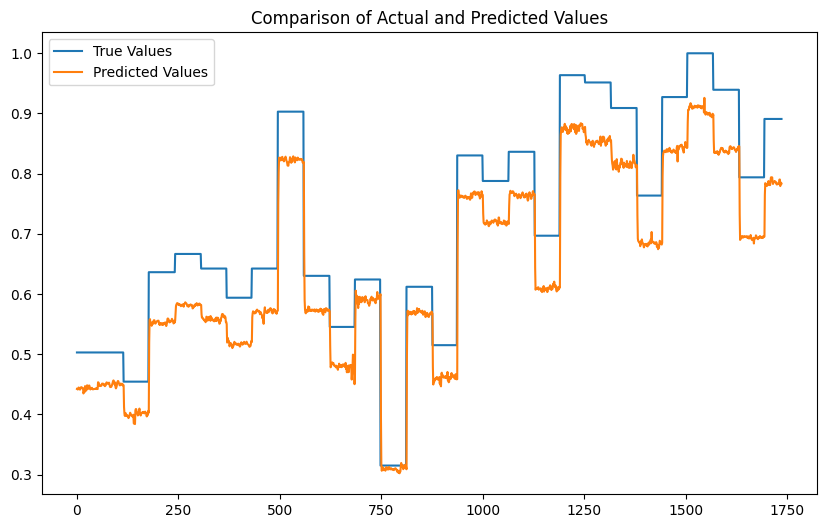

In [ ]:
import matplotlib.pyplot as plt

# Predicting
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='True Values')
plt.plot(y_pred, label='Predicted Values')
plt.title('Comparison of Actual and Predicted Values')
plt.legend()
plt.show()

### Evaluating the model
We would like to use the Mean squared Error to evaluate this model and better compare it to the other models.

In [ ]:
test_loss = model.evaluate(X_test_reshaped, y_test)
print(f'Test Loss: {test_loss}')

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 233us/step - loss: 0.0051
Test Loss: 0.0062643010169267654


### Hypertuning the parameters
We will perform hyperparameter tuning for the Vanilla Neural Network (VNN) where we explore different combinations of parameters such as the number of units in input and hidden layers, learning rate, and momentum. The Keras Tuner systematically searches these hyperparameters to minimize the mean squared error loss. This optimization process fine-tunes the VNN's architecture and training parameters, tailored specifically for forecasting firm earnings. By selecting the best configuration, the model's performance is optimized, leading to more accurate predictions.

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import SGD
from kerastuner.tuners import RandomSearch

n_steps = 4  # This should match the number of timesteps you decided to use in your sequences
n_features = merged_df.shape[1]  # Number of features in your dataset

def build_model(hp):
    model = Sequential([
        Dense(hp.Int('units_input', min_value=32, max_value=512, step=32), activation='relu', input_shape=(n_steps * n_features,)),
        Dropout(0.2),
        Dense(hp.Int('units_hidden', min_value=32, max_value=512, step=32), activation='relu'),
        Dropout(0.2),
        Dense(1)  # Output layer - assumes a single output
    ])

    # Compile the model
    sgd_optimizer = SGD(
        learning_rate=hp.Float('learning_rate', min_value=0.01, max_value=0.1, step=0.01),
        momentum=hp.Float('momentum', min_value=0.0, max_value=0.9, step=0.1)
    )
    model.compile(optimizer=sgd_optimizer, loss='mean_squared_error')

    return model

# Define the Keras Tuner
tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=5,  # The number of different models to try
    executions_per_trial=3,  # The number of times to train each model. This is useful to reduce results variance
    directory='my_dir',  # The directory where the results are stored
    project_name='vnn'  # The name of the project. This will be a subdirectory in the directory
)

# Reshape the input data
X_train_reshaped = X_train.reshape(X_train.shape[0], -1)
X_test_reshaped = X_test.reshape(X_test.shape[0], -1)

# Run the hyperparameter search
tuner.search(X_train_reshaped, y_train, epochs=200, validation_data=(X_test_reshaped, y_test))

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Make predictions on the test set
y_pred = best_model.predict(X_test_reshaped)

Trial 5 Complete [00h 01m 33s]
val_loss: 0.001501474529504776

Best val_loss So Far: 0.00136038971443971
Total elapsed time: 00h 08m 59s
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'SGD', because it has 2 variables whereas the saved optimizer has 8 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Below we will plot and find the MSE for the tuned model and see how well it does.

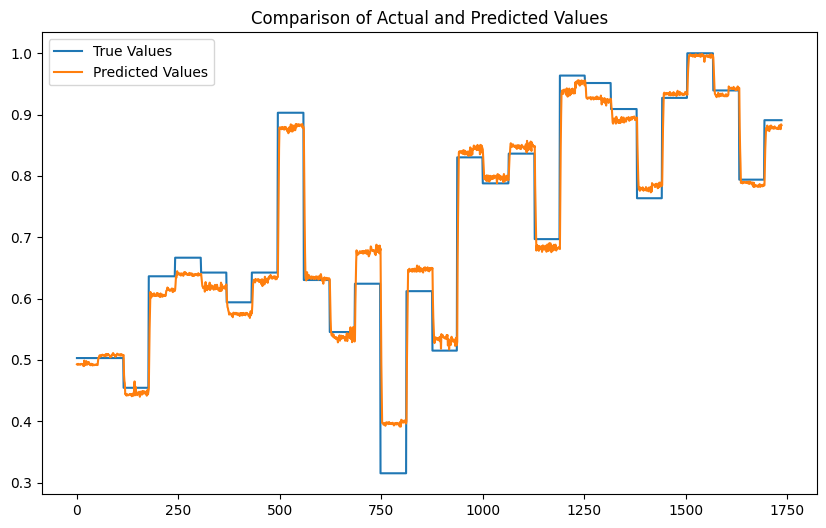

In [ ]:
import matplotlib.pyplot as plt

# Predicting
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='True Values')
plt.plot(y_pred, label='Predicted Values')
plt.title('Comparison of Actual and Predicted Values')
plt.legend()
plt.show()

In [ ]:
test_loss = best_model.evaluate(X_test_reshaped, y_test)
print(f'Test Loss: {test_loss}')

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 950us/step - loss: 0.0011   
Test Loss: 0.0012310747988522053


### VNN Result Explanation 
The Vanilla Neural Network (VNN) used in this project is a feedforward neural network architecture comprising input, hidden, and output layers. In the initial model configuration, two hidden layers with 50 neurons each and ReLU activation functions are employed, along with dropout layers to mitigate overfitting. This architecture is well-suited for financial forecasting tasks due to its ability to capture complex non-linear relationships present in the data. The mean squared error (MSE) of 0.0062643010169267654 obtained from the initial model reflects its initial performance.

However, through hyperparameter tuning using techniques like Random Search, we fine-tune the model's parameters such as the number of neurons in the layers, learning rate, and momentum. This optimization process aims to identify the optimal configuration that minimizes the validation loss, resulting in improved model performance. As a result of hyperparameter tuning, the mean squared error decreases significantly to 0.0012310747988522053. This reduction in MSE signifies that the hypertuned model is better able to capture the underlying patterns in the financial data, leading to more accurate predictions of firm earnings.

## Why this model for this problem
Support Vector Machines (SVMs) offer a compelling approach for forecasting future firm earnings based on financial data due to their robustness in handling high-dimensional datasets and ability to capture complex relationships between features. In financial forecasting, where datasets often contain numerous predictors and intricate patterns, SVMs excel at identifying the optimal decision boundary that separates different market regimes or states, thereby enabling accurate prediction of earnings trends. Additionally, SVMs can effectively handle both linear and non-linear relationships through the use of appropriate kernel functions, making them versatile for capturing the nuanced dynamics of financial markets. Their ability to generalize well to unseen data further enhances their utility in this context, as it ensures reliable predictions even in the face of changing market conditions.

## Model Architecture
SVM aims to find the optimal hyperplane that separates data classes while maximizing margin. It utilizes support vectors and kernel functions to handle non-linear relationships efficiently. Regularization prevents overfitting, and the decision function assigns new data points to classes based on their position relative to the hyperplane.

In [ ]:
from sklearn.svm import SVR

# Create a Support Vector Regressor
svr = SVR(kernel='rbf', C=1.0, epsilon=0.2)

# Train the model
svr.fit(X_train_reshaped, y_train)

# Make predictions on the test set
y_pred = svr.predict(X_test_reshaped)

We'd like to plot this data against the original test values to get a visual representation of how it performed.

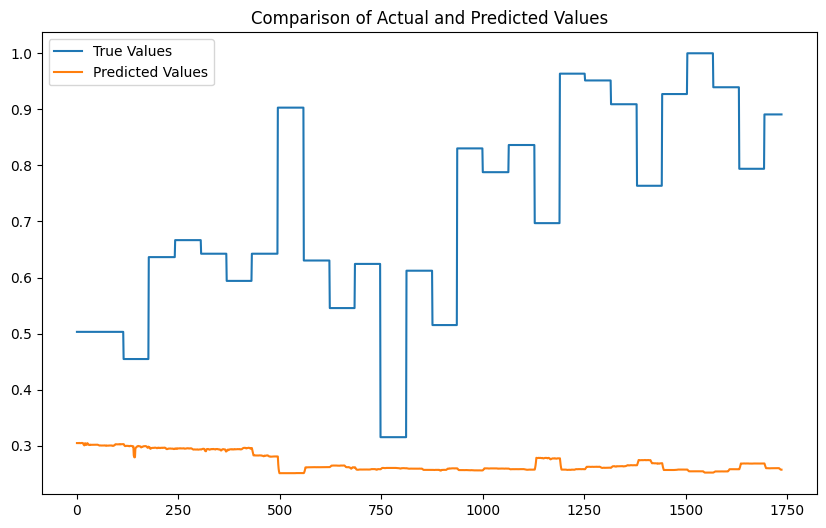

In [ ]:
import matplotlib.pyplot as plt

# Predicting
predicted_values = svr.predict(X_test_reshaped)
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='True Values')
plt.plot(predicted_values, label='Predicted Values')
plt.title('Comparison of Actual and Predicted Values')
plt.legend()
plt.show()

### Evaluating the model
We would like to use the Mean squared Error to evaluate this model and better compare it to the other models.

In [ ]:
from sklearn.metrics import mean_squared_error
# Make predictions on the test set
y_pred = svr.predict(X_test_reshaped)
# Calculate the mean squared error
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error: ", mse)

Mean Squared Error:  0.23455574605030258


### Hypertuning Parameters
We'd like to make this model more robust and ensure that the parameters are well suited for this specific usecase. We will use GridSearchCV to hypertune the parameters inorder to get a better prediction

In [ ]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'C': [0.1, 1, 10, 100],
    'epsilon': [0.1, 0.2, 0.3, 0.4, 0.5],
    'kernel': ['rbf', 'linear', 'poly']
}

# Create a Support Vector Regressor
svr = SVR()

# Create GridSearchCV object
grid_search = GridSearchCV(svr, param_grid, cv=5, scoring='neg_mean_squared_error')

# Fit the model
grid_search.fit(X_train_reshaped, y_train)

# Get the best parameters
best_params = grid_search.best_params_

print("Best parameters: ", best_params)

# Train the model with the best parameters
svr_best = SVR(**best_params)
svr_best.fit(X_train_reshaped, y_train)

# Make predictions on the test set
y_pred = svr_best.predict(X_test_reshaped)

Best parameters:  {'C': 0.1, 'epsilon': 0.1, 'kernel': 'poly'}


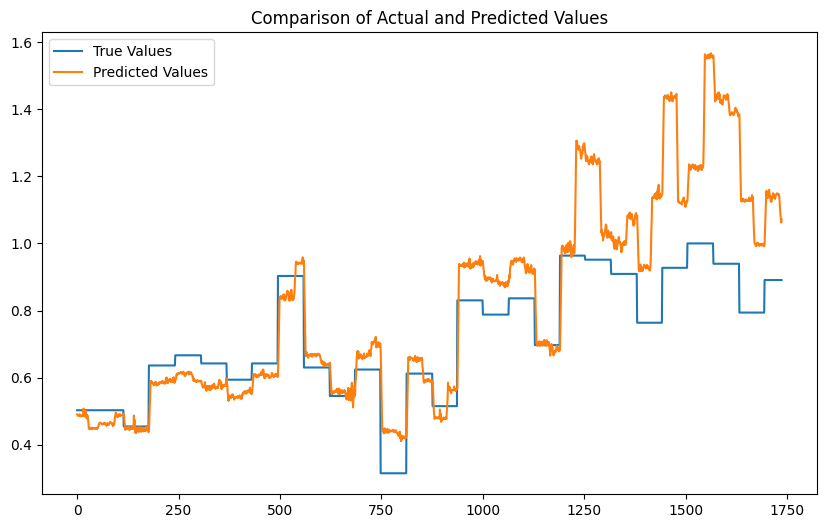

In [ ]:
import matplotlib.pyplot as plt

# Predicting
predicted_values = svr_best.predict(X_test_reshaped)
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='True Values')
plt.plot(predicted_values, label='Predicted Values')
plt.title('Comparison of Actual and Predicted Values')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error
# Make predictions on the test set
y_pred = svr_best.predict(X_test_reshaped)
# Calculate the mean squared error
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error: ", mse)

Mean Squared Error:  0.03431552704503399


### SVM Result Explanation
The SVM branch with parameters {'C': 0.1, 'epsilon': 0.1, 'kernel': 'poly'} likely performed well due to its choice of parameters tailored to the problem. A polynomial kernel might have effectively captured the non-linear relationships in the data, while a smaller regularization parameter (C) and epsilon might have helped in achieving a smoother fit with lesser error. Conversely, SVM with {'kernel': 'rbf', 'C': 1.0, 'epsilon': 0.2} exhibited higher Mean Squared Error (MSE), potentially due to overfitting or less suitable parameter choices for the data, particularly with the radial basis function kernel, which might have been sensitive to the given C and epsilon values. Overall the SVM performed well due to its ability to effectively handle complex relationships in the financial data and generalize well to unseen data.

### Why this model for this problem
The reason why Random Forest is effective for this project, which involves predicting the estimated Earnings Per Share (EPS), includes:

Overfitting Prevention: Random Forest helps to prevent overfitting, a common problem in machine learning where a model performs well on training data but poorly on unseen data. This is achieved by averaging the predictions from multiple decision trees.

Handling High Dimensionality: Random Forest can effectively handle datasets with a large number of features. It does this by randomly selecting a subset of features at each node when building the trees.

Interpretability: Random Forest provides a measure of feature importance, which can help in understanding which features are most influential in predicting the EPS.

Non-linearity: Financial data often exhibit non-linear relationships. Random Forest does not make any assumptions about the underlying relationships between features and the target variable, making it a suitable choice for this project.

Robustness to Outliers: Random Forest is less sensitive to outliers in the data. This is particularly useful in financial data, which can often contain outliers due to sudden market changes.

### Reshaping data
X_train.reshape(X_train.shape[0], -1) and X_test_reshaped = X_test.reshape(X_test.shape[0], -1) reshapes X_train into a two-dimensional array where the number of rows is the same as in the original X_train array, and the number of columns is such that the total number of elements in the array remains the same. This is to fine tune the data so it can be inputted into the RandomForestRegressor.

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Create a Random Forest Regressor
rf = RandomForestRegressor(n_estimators=200, random_state=0)

# Train the model
# Reshape the input data
X_train_reshaped = X_train.reshape(X_train.shape[0], -1)
X_test_reshaped = X_test.reshape(X_test.shape[0], -1)

# Train the model
rf.fit(X_train_reshaped, y_train)

# Make predictions on the test set
y_pred = rf.predict(X_test_reshaped)

We'd like to plot this data against the original test values to get a visual representation of how it performed.

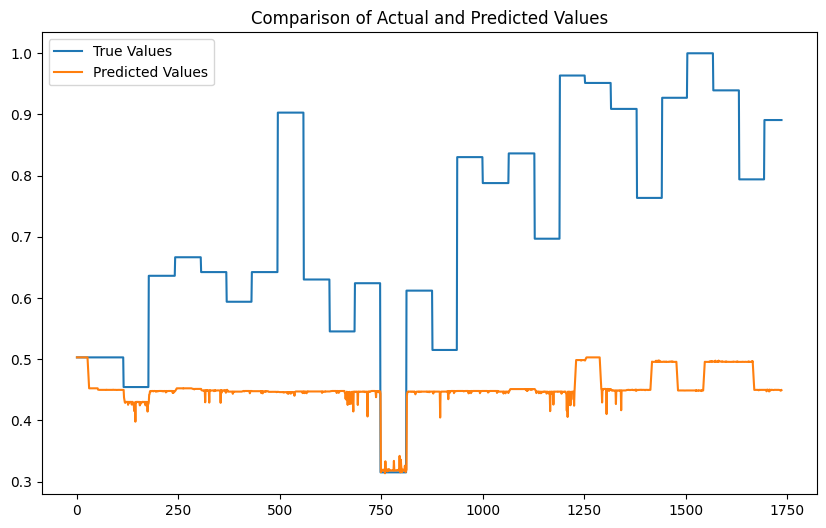

In [ ]:
import matplotlib.pyplot as plt

# Predicting
predicted_values = rf.predict(X_test_reshaped)
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='True Values')
plt.plot(predicted_values, label='Predicted Values')
plt.title('Comparison of Actual and Predicted Values')
plt.legend()
plt.show()

### Evaluating the model
Mean Squared Error (MSE) is ideal for evaluating the Random Forest model in forecasting firm earnings because it penalizes larger errors, enhancing prediction accuracy. Its mathematical properties facilitate optimization and interpretation, while providing a consistent, standard metric for comparing model performance. MSE aligns well with the project's goal of minimizing forecast errors.

In [ ]:
from sklearn.metrics import mean_squared_error

y_pred = rf.predict(X_test_reshaped)
test_loss = mean_squared_error(y_test, y_pred)
print(f'Test Loss: {test_loss}')

Test Loss: 0.09723491972110265


### Hypertuning Parameters
We'd like to try hypertuning the parameters to the original random forest regressor to try to get better results than the previous model. To do this we'd use GridSearchCV.

In [ ]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Create a base model
rf = RandomForestRegressor(random_state=0)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                           cv=3, n_jobs=-1, verbose=2)

# Fit the grid search to the data
grid_search.fit(X_train_reshaped, y_train)

# Get the best parameters
best_params = grid_search.best_params_

# Train the model using the best parameters
rf_best = RandomForestRegressor(**best_params, random_state=0)
rf_best.fit(X_train_reshaped, y_train)

# Make predictions on the test set using the new model
y_pred = rf_best.predict(X_test_reshaped)

Fitting 3 folds for each of 288 candidates, totalling 864 fits
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.0s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.4s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.3s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   4.1s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   2.0s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   2.4s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   4.5s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; tota

Below are the best found parameters and we will use them to train our rf_best model

In [ ]:
# Train the model using the best parameters
rf_best = RandomForestRegressor(**best_params, random_state=0)
rf_best.fit(X_train_reshaped, y_train)
best_params

{'bootstrap': False,
 'max_depth': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 400}

In [ ]:
# Make predictions on the test set using the new model
y_pred = rf_best.predict(X_test_reshaped)

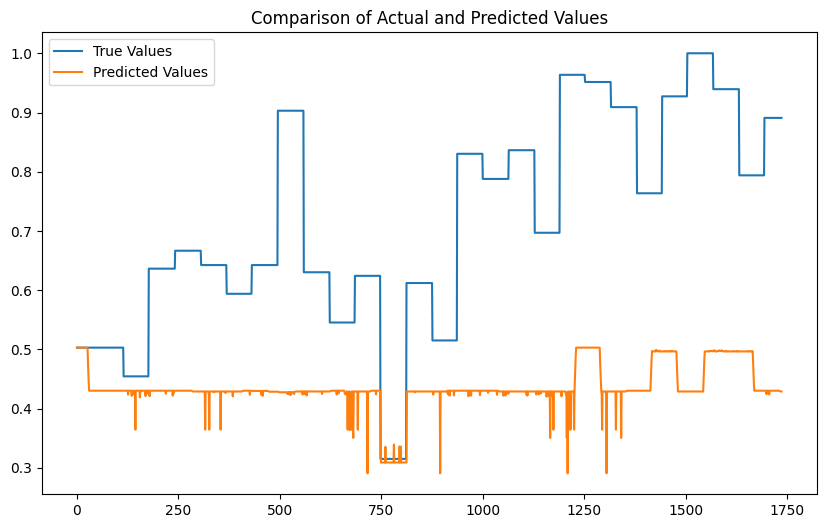

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='True Values')
plt.plot(y_pred, label='Predicted Values')
plt.title('Comparison of Actual and Predicted Values')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error
y_pred = rf_best.predict(X_test_reshaped)
test_loss = mean_squared_error(y_test, y_pred)
print(f'Test Loss: {test_loss}')

Test Loss: 0.10586315977155072


### Random Forest Result Explanation
The Random Forest model may underperform compared to RNNs and XGBoost in this project due to its limited ability to capture temporal dependencies and sequential patterns inherent in financial data. While Random Forests are robust for general prediction tasks, they lack the capability of RNNs to model time series data effectively. Additionally, XGBoost's ability to handle complex feature interactions and non-stationarity in financial metrics provides a significant edge. The averaging nature of Random Forests can also dilute subtle but crucial patterns, leading to less accurate earnings forecasts. We can also notice that hypertuning the parameters can also overfit the model as the second model performs slightly worse than the first one. 

# RNN (Franco)

## Why this model for this problem

* This is the Recurrent Neural Network approach, as done by the whitepaper. RNNs with Long Short Term Memory units prove to be suited for predicting earnings per share, because of its capacity to process data sequentially and retain information across longer time periods. The RNN takes the indicators in sequences (EPS is updated quarterly though we have daily data for our features). The LSTM layers selectively retain or forget information, continuously refined as more sequences are processed.

## Model Architecture

Our RNN will utilize a Long Short Term Memory Model, as justified by its advantages for time series.

Preparing the data, declaring the batch size and obtaining the number of features.

In [ ]:
from sklearn.preprocessing import StandardScaler
import tensorflow as tf

batch_size = 64
n_steps = 50  
n_features = merged_df.shape[1]

# `merged_df` needs numeric types no missing values
data = merged_df.values

Given data limitations we apply a forward fill, backward fill, and fill with mean to ensure that missing values in the dataframe are cleaned up.

In [ ]:
# Forward Fill
merged_df.ffill(inplace=True)

# Backward Fill
merged_df.bfill(inplace=True)

# Fill with Mean 
merged_df.fillna(merged_df.mean(), inplace=True)


Here the data is properly normalized, and then reevaluated to solve any NaN and Inf values. Initially, a StandardScaler approach was used until it resulted in notable bias. Switching to a MinMax scaler from 0 to 1 fit the data better.

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Apply MinMaxScaler for better normalization
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(merged_df.values)

# Ensure no infinite or NaN values after scaling
data_scaled = np.nan_to_num(data_scaled)

# Ensure no infinite or NaN values after scaling
if np.isinf(data_scaled).any() or np.isnan(data_scaled).any():
    print("Infinite or NaN values found after scaling.")
    data_scaled = np.nan_to_num(data_scaled)  # Replace NaNs and Infs


Here the dataset is transformed into sequences, and split into training and testing data.

In [ ]:
# Reshape data to fit the RNN input shape
def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(n_steps, len(data)):
        X.append(data[i-n_steps:i, :])
        y.append(data[i, 5])  # Assuming the first column is the target variable
    return np.array(X), np.array(y)

X, y = create_sequences(data_scaled, n_steps)

# Split the dataset
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

Here we define the RNN model. The model consists of two LSTM layers, two dropout layers, and one dense layer.

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

n_steps = 50  
n_features = merged_df.shape[1]  

# Define the RNN model
model = Sequential([
    LSTM(50, activation='tanh', input_shape=(n_steps, n_features), return_sequences=True),
    Dropout(0.2),
    LSTM(50, activation='tanh'),
    Dropout(0.2),
    Dense(1)  # Output layer - assumes a single output per sequence
])

# Display model summary to verify its structure
model.summary()


C:\Users\franc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50, 50)         │        12,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,251 (125.98 KB)

 Trainable params: 32,251 (125.98 KB)

 Non-trainable params: 0 (0.00 B)

Compile the model using Stochastic Gradient Descent.

In [ ]:
# Compile the model using SGD optimizer
sgd_optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
model.compile(optimizer=sgd_optimizer, loss='mean_squared_error')

Run the epochs to train the model.

In [ ]:
history = model.fit(X_train, y_train, epochs=40, batch_size=32, verbose=1, validation_split=0.2)

Epoch 1/40
173/173 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.0032 - val_loss: 0.0443
Epoch 2/40
173/173 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 8.0381e-04 - val_loss: 0.0452
Epoch 3/40
173/173 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 6.0085e-04 - val_loss: 0.0406
Epoch 4/40
173/173 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 5.1804e-04 - val_loss: 0.0375
Epoch 5/40
173/173 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 4.4197e-04 - val_loss: 0.0362
Epoch 6/40
173/173 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 4.2401e-04 - val_loss: 0.0312
Epoch 7/40
173/173 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 4.4282e-04 - val_loss: 0.0300
Epoch 8/40
173/173 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 4.0037e-04 - val_loss: 0.0258
Epoch 9/40
173/173 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 3.2655e-04 - val_loss: 0.0249
Epoch 10/40
173/173 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 3.4427e-04 - val_loss: 0.0208
Epoch 11/40
173/173 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 3.0944e-04 - val_loss: 0.0190
E

Here we plot the actual and predicted values of our earnings per share.

## Fitted Model and Results

54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


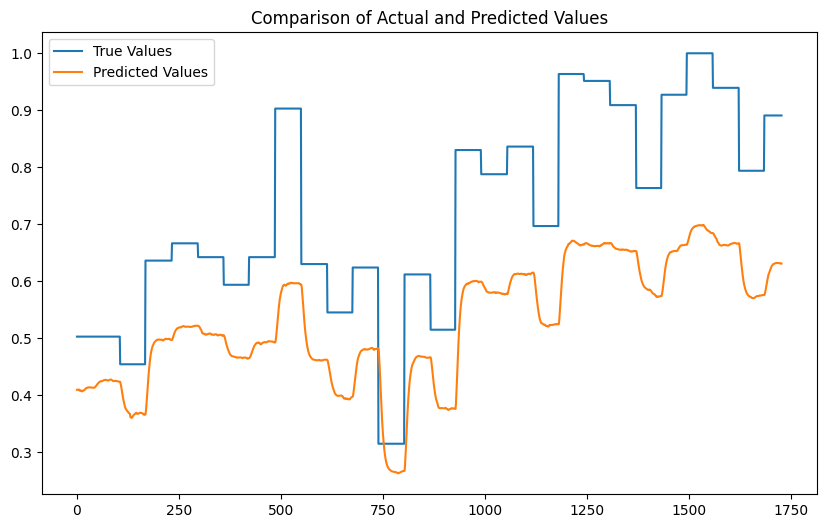

In [ ]:
import matplotlib.pyplot as plt

# Plotting
predicted_values = model.predict(X_test)
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='True Values')
plt.plot(predicted_values, label='Predicted Values')
plt.title('Comparison of Actual and Predicted Values')
plt.legend()
plt.show()

In [ ]:
# Evaluate the model
test_loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}')

54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0260
Test Loss: 0.0425402969121933


Using an RNN model approach to predict earnings per share generally captures the trends in the actual data, as evidenced by the convergence of predicted and true values shown in the graph. However, there are noticeable offsets in the prediction, particularly during peaks and troughs, suggesting issues with scaling or model sensitivity. Over the course of 400 epochs, both training and validation losses significantly decrease, indicating effective learning and generalization, with the final test loss settling at a reasonably low value. This underscores the model's ability to understand underlying patterns but also highlights the areas for further improvement and tuning such as refining the scaling approach, adjusting the network architecture, enhancing feature engineering, and experimenting with hyperparameters to optimize performance further and reduce the amplitude offset between predicted and true values.

## RNN results (Franco)


## Model Architecture

Our RNN will utilize a Long Short Term Memory Model, as justified by its advantages for time series.

In [26]:
from sklearn.preprocessing import StandardScaler
import tensorflow as tf

batch_size = 64
n_steps = 4
n_features = merged_df.shape[1]

# `merged_df` needs numeric types no missing values
data = merged_df.values

# Normalize features
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

In [27]:
# Forward Fill
merged_df.ffill(inplace=True)

# Backward Fill
merged_df.bfill(inplace=True)

# Fill with Mean (ensure to apply this per feature if your data isn't homogeneous)
merged_df.fillna(merged_df.mean(), inplace=True)


In [28]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Apply MinMaxScaler for better normalization
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(merged_df.values)

# Ensure no infinite or NaN values after scaling
data_scaled = np.nan_to_num(data_scaled)

# Ensure no infinite or NaN values after scaling
if np.isinf(data_scaled).any() or np.isnan(data_scaled).any():
    print("Infinite or NaN values found after scaling.")
    data_scaled = np.nan_to_num(data_scaled)  # Replace NaNs and Infs


In [29]:
# Reshape data to fit the RNN input shape
def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(n_steps, len(data)):
        X.append(data[i-n_steps:i, :])
        y.append(data[i, 5])  # Assuming the first column is the target variable
    return np.array(X), np.array(y)

X, y = create_sequences(data_scaled, n_steps)

# Split the dataset
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [30]:
merged_df.columns

Index(['Daily_Return_percent_SP', 'Daily_Return_percent_VIX', 'Dividends',
       'Volume', 'Daily_Return_percent', 'Estimated EPS', 'Reported EPS',
       'totalAssets', 'Equity Ratio'],
      dtype='object')

In [31]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Model configuration - these need to be adjusted based on your dataset
n_steps = 50  # This should match the number of timesteps you decided to use in your sequences
n_features = merged_df.shape[1]  # Number of features in your dataset

# Define the RNN model
model = Sequential([
    LSTM(50, activation='tanh', input_shape=(n_steps, n_features), return_sequences=True),
    Dropout(0.2),
    LSTM(50, activation='tanh'),
    Dropout(0.2),
    Dense(1)  # Output layer - assumes a single output per sequence
])

# Display model summary to verify its structure
model.summary()


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50, 50)         │        12,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,251 (125.98 KB)

 Trainable params: 32,251 (125.98 KB)

 Non-trainable params: 0 (0.00 B)

In [32]:
# Compile the model using SGD optimizer
sgd_optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
model.compile(optimizer=sgd_optimizer, loss='mean_squared_error')

In [33]:
# Assuming X_train and y_train are already defined and properly shaped
history = model.fit(X_train, y_train, epochs=200, batch_size=32, verbose=1, validation_split=0.2)

Epoch 1/200
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0036 - val_loss: 0.0519
Epoch 2/200
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.0572e-04 - val_loss: 0.0486
Epoch 3/200
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.7424e-04 - val_loss: 0.0459
Epoch 4/200
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.5631e-04 - val_loss: 0.0456
Epoch 5/200
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.4998e-04 - val_loss: 0.0439
Epoch 6/200
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.0507e-04 - val_loss: 0.0442
Epoch 7/200
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.1821e-04 - val_loss: 0.0430
Epoch 8/200
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.0450e-04 - val_loss: 0.0429
Epoch 9/200
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.9281e-04 - val_loss: 0.0421
Epoch 10/200
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.8565e-04 - val_loss: 0.0419
Epoch 11/200
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.0707e-04 - val_loss: 0.0410
E

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


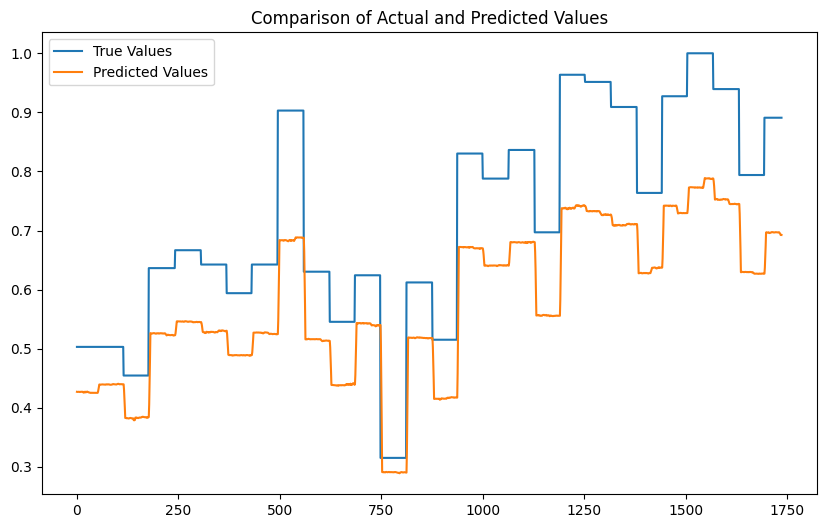

In [34]:
import matplotlib.pyplot as plt

# Predicting
predicted_values = model.predict(X_test)
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='True Values')
plt.plot(predicted_values, label='Predicted Values')
plt.title('Comparison of Actual and Predicted Values')
plt.legend()
plt.show()

In [35]:
# Evaluate the model
test_loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}')

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 479us/step - loss: 0.0144
Test Loss: 0.022611675783991814


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 50, 50)         │        12,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 50, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,251 (125.98 KB)

 Trainable params: 32,251 (125.98 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0287 - val_loss: 0.0411
Epoch 2/200
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.2300e-04 - val_loss: 0.0399
Epoch 3/200
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.0833e-04 - val_loss: 0.0399
Epoch 4/200
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.7233e-04 - val_loss: 0.0400
Epoch 5/200
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.3286e-04 - val_loss: 0.0405
Epoch 6/200
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.6560e-04 - val_loss: 0.0396
Epoch 7/200
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.6227e-04 - val_loss: 0.0397
Epoch 8/200
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.5329e-04 - val_loss: 0.0394
Epoch 9/200
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.3040e-04 - val_loss: 0.0388
Epoch 10/200
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.9415e-04 - val_loss: 0.0398
Epoch 11/200
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.0138e-04 - val_loss: 0.0381
E

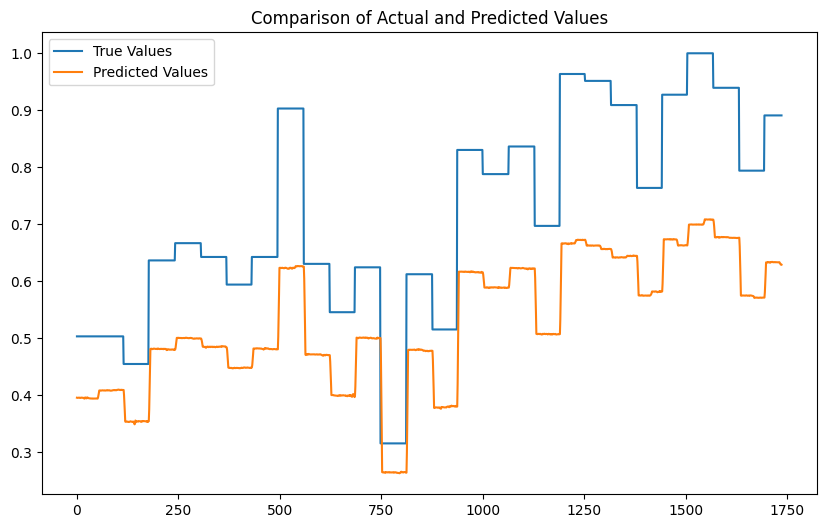

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 576us/step - loss: 0.0263
Test Loss: 0.040641769766807556


In [36]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Lambda
import tensorflow.keras.backend as K

# Define the RNN model with bias correction included
model = Sequential([
    LSTM(50, activation='tanh', input_shape=(n_steps, n_features), return_sequences=True),
    Dropout(0.2),
    LSTM(50, activation='tanh'),
    Dropout(0.2),
    Dense(1),  # Output layer - initially outputs the raw predictions
    Lambda(lambda x: x + K.constant(0.5))  # Adding bias correction directly in the model
])

# Display model summary to verify its structure
model.summary()

# Compile the model using SGD optimizer
sgd_optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
model.compile(optimizer=sgd_optimizer, loss='mean_squared_error')

# Assuming X_train and y_train are already defined and properly shaped
history = model.fit(X_train, y_train, epochs=200, batch_size=32, verbose=1, validation_split=0.2)

# Predicting and plotting results
import matplotlib.pyplot as plt

predicted_values = model.predict(X_test)
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='True Values')
plt.plot(predicted_values, label='Predicted Values')
plt.title('Comparison of Actual and Predicted Values')
plt.legend()
plt.show()

# Evaluate the model
test_loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}')


## Model Specific Preprocessing 

## Model Specific Tuning

## Model Evaluation

## Fitted Model and Results
    - Report on hyper parameters
    - Report on fit quality
    - Ideas on improvement if the model was continued to be

## RNN results (Franco)


## Fitted Model and Results
    - Report on hyper parameters
    - Report on fit quality
    - Ideas on improvement if the model was continued to be